<!-- # Data Investigation

In this notebook I investigate the `bow` dataset to try and build a replicable model for all weapon types. -->

In [1]:
%load_ext autoreload
%autoreload 2

import random

# Set the seed to an integer value
random.seed(42) 

from __future__ import annotations
from pathlib import Path
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys, os
project_root = os.path.abspath(os.path.join(os.getcwd(), "../.."))
sys.path.insert(0, project_root)

import nest_asyncio; nest_asyncio.apply()

# debugging ModuleNotFound errors
print("CWD:", os.getcwd())

print("sys.path:")
for p in sys.path:
    print("   ", p)

CWD: /Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/src/research/scripts
sys.path:
    /Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/src
    /opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python313.zip
    /opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13
    /opt/homebrew/Cellar/python@3.13/3.13.7/Frameworks/Python.framework/Versions/3.13/lib/python3.13/lib-dynload
    
    /Users/yokurang/Documents/Recruiting/AlphaGrep/path-of-elix/take_home_project_poe/.venv/lib/python3.13/site-packages


In [2]:
from utils import preview_dataset, quick_validation, summarize_feature_set

bow = preview_dataset("securable/training_data/overall/weapon_bow_overall_standard.parquet")

Dataset: weapon_bow_overall_standard.parquet
Shape: 663 rows × 46 columns

Columns:
   1. id
   2. league
   3. realm
   4. indexed
   5. seller
   6. fee
   7. price_amount_original
   8. price_currency_original
   9. price_type
  10. price_amount_in_base
  11. price_currency_in_base
  12. price_rate_to_base
  13. verified
  14. rarity
  15. base_type
  16. type_line
  17. name
  18. ilvl
  19. identified
  20. corrupted
  21. duplicated
  22. unmodifiable
  23. category
  24. stack_size
  25. max_stack_size
  26. support
  27. gem_sockets
  28. weapon_requirements
  29. gem_tabs
  30. gem_background
  31. gem_skill
  32. sec_descr_text
  33. flavour_text
  34. descr_text
  35. sockets
  36. properties
  37. requirements
  38. granted_skills
  39. socketed_items
  40. extended
  41. rune_mods
  42. desecrated_mods
  43. implicit_mods
  44. explicit_mods
  45. veiled_mods
  46. desecrated

First 5 rows:
                                                              id   league realm    

## Data Inspection and Feature Engineering

In this section, I will drop unnecessary columns and clean up the feature set. Additionally, I will engineer the feature set for training and make sure that the features are not collinear with each other. 

In [9]:
# from weapon_features import (
#     load_and_process_item_data_split,
#     validate_features,
# )

# (X, y, craft_meta), (uniq_X, uniq_y, uniq_meta) = load_and_process_item_data_split(
#     "training_data/overall/weapon_bow_overall_standard.parquet",
#     compute_dps=True,
# )

# print("=== CRAFTABLES ===")
# validate_features(X, y)
# summarize_feature_set(X, y, craft_meta, show_variance_analysis=True)

# print("\n=== UNIQUES ===")
# validate_features(uniq_X, uniq_y)
# summarize_feature_set(uniq_X, uniq_y, uniq_meta, show_variance_analysis=True)


In [3]:
from features_poex import prepare_feature_sets_from_raw, validate_features
res = prepare_feature_sets_from_raw(
    "training_data/overall/weapon_bow_overall_standard.parquet",
)

X, y, craft_meta = res["craft_all"]
Xu, yu, mu = res["unique_all"]

validate_features(X, y)
summarize_feature_set(X, y, craft_meta, show_variance_analysis=True)


Dataset: 249 samples, 32 features
Price range: 0.06 - 0.74
Mean price: 0.13, Median: 0.06

key features present:
  pdps: 173 nonzero, avg=42.163
  fdps: 38 nonzero, avg=39.022
  cdps: 30 nonzero, avg=13.418
  ldps: 43 nonzero, avg=44.063
  chaos_dps: 89 nonzero, avg=17.975
  open_slots_est: 181 nonzero, avg=3.210
  highest_explicit_tier_num: 196 nonzero, avg=7.653
  highest_explicit_level: 196 nonzero, avg=29.031
  req_level: 242 nonzero, avg=34.773
  req_dex: 241 nonzero, avg=61.680
  implicit_mod_count: 139 nonzero, avg=1.000
  explicit_mod_count: 196 nonzero, avg=3.168
  other_mods_avg_value: 128 nonzero, avg=9.495
  other_mods_avg_level: 128 nonzero, avg=16.908
  is_corrupted: 51 nonzero, avg=1.000
FEATURE SET SUMMARY
Features: 249 samples × 32 features
Targets:  2 target variable(s)
Data validation passed

Feature Categories:
  dps: 5
  requirements: 2
  boolean_flags: 3
  continuous: 22

Target Analysis:
  price: mean=0.13, std=0.16, range=[0.1, 0.7]
  log_price: mean=0.11, std=0

{'is_clean': True,
 'feature_types': {'dps': ['pdps', 'fdps', 'cdps', 'ldps', 'chaos_dps'],
  'rarity': [],
  'sockets': [],
  'requirements': ['req_level', 'req_dex'],
  'boolean_flags': ['implicit_mod_count', 'is_corrupted', 'skill_level'],
  'continuous': ['ilvl',
   'socket_count',
   'crit_chance',
   'quality',
   'explicit_mod_count',
   'other_mods_avg_value',
   'other_mods_avg_level',
   'other_mods_count',
   'highest_explicit_tier_num',
   'highest_explicit_level',
   'spirit',
   'life_leech',
   'increased_damage',
   'physical_damage_pct',
   'accuracy_rating',
   'attack_speed_pct',
   'dexterity',
   'light_radius',
   'life_on_kill',
   'reduced_requirements',
   'mana_leech',
   'open_slots_est'],
  'other': []}}

In [4]:
from features_preperation import prepare_design_matrix, validate_design_matrix, print_feature_summary

X, info = prepare_design_matrix(
    X,
    one_hot_prefixes=(),           # you likely have no OHE; leave empty
    drop_zero_variance=True,
    standardize=True,              # z-score
    standardize_fit_stats=None,    # None = fit scaler here
    verbose=True,
)

# Save scaler for inference
scaler = info["standardize"]

# 3) Validate & summarize
validate_design_matrix(X, y, check_multicollinearity=True)
print_feature_summary(X)

No zero-variance features found
Standardized 32 numeric columns (fit).

Final feature count: 32
Feature Matrix: 249 samples × 32 features

Feature Types:
  dps_features: 5
  numeric: 25
  requirements: 2

Numeric Features: 32 total
  Value range: [-5.17, 10.44]
  Mean variance: 1.0000


In [12]:
X.columns

Index(['ilvl', 'socket_count', 'req_level', 'req_dex', 'crit_chance',
       'quality', 'implicit_mod_count', 'explicit_mod_count',
       'other_mods_avg_value', 'other_mods_avg_level', 'other_mods_count',
       'highest_explicit_tier_num', 'highest_explicit_level', 'is_corrupted',
       'pdps', 'fdps', 'cdps', 'ldps', 'chaos_dps', 'skill_level', 'spirit',
       'life_leech', 'increased_damage', 'physical_damage_pct',
       'accuracy_rating', 'attack_speed_pct', 'dexterity', 'light_radius',
       'life_on_kill', 'reduced_requirements', 'mana_leech', 'open_slots_est'],
      dtype='object')

In [5]:
from vif import compute_vif
vif, analysis = compute_vif(X)
vif

VIF Analysis Summary:
Total features: 32
High multicollinearity (VIF > 10.0): 7
Moderate multicollinearity (5 < VIF <= 10.0): 5
Max VIF: 23.61
Mean VIF: 6.04

High VIF features:
  explicit_mod_count: 23.61
  chaos_dps: 16.40
  open_slots_est: 16.28
  req_dex: 16.00
  pdps: 15.62
  implicit_mod_count: 15.06
  req_level: 10.68

Multicollinearity detected: True


,feature,VIF,tolerance
7,explicit_mod_count,23.605608,0.042363
18,chaos_dps,16.404699,0.060958
31,open_slots_est,16.278778,0.061430
3,req_dex,16.003252,0.062487
14,pdps,15.617023,0.064033
6,implicit_mod_count,15.064920,0.066379
2,req_level,10.682867,0.093608
0,ilvl,9.340453,0.107061
12,highest_explicit_level,6.940717,0.144077
19,skill_level,6.394421,0.156386


In [12]:
from vif import remove_high_vif_features
X, _ = remove_high_vif_features(X)

Iteration 1: removed 'explicit_mod_count' (VIF=23.61); 31 features remain.
Iteration 2: removed 'req_dex' (VIF=15.77); 30 features remain.
Iteration 3: removed 'chaos_dps' (VIF=15.04); 29 features remain.
Iteration 4: removed 'open_slots_est' (VIF=10.47); 28 features remain.
Converged after 4 iterations (max VIF = 8.92 ≤ 10.0).
Final max VIF: 8.92


In [13]:
vif, analysis = compute_vif(X)
vif

VIF Analysis Summary:
Total features: 28
High multicollinearity (VIF > 10.0): 0
Moderate multicollinearity (5 < VIF <= 10.0): 5
Max VIF: 8.92
Mean VIF: 2.93

Multicollinearity detected: False


,feature,VIF,tolerance
12,pdps,8.920672,0.112099
5,implicit_mod_count,7.543726,0.132560
2,req_level,7.493542,0.133448
0,ilvl,7.093647,0.140971
10,highest_explicit_level,6.175979,0.161918
7,other_mods_avg_level,4.251125,0.235232
6,other_mods_avg_value,3.937161,0.253990
8,other_mods_count,3.344143,0.299030
16,skill_level,2.992646,0.334152
9,highest_explicit_tier_num,2.822018,0.354356


Features are within 10 VIF. Good enough to proceed. 

## Data Investigation

In this section, I will attempt to fit a MLR model on the target variables to see if our features are linear against prices. This will provide guidance on what kind of models are appropriate for the task of predicting price.

=== Cross-Validation (Huber MLR) ===
[Fold 1/5] R² = -0.2311
[Fold 2/5] R² = 0.3539
[Fold 3/5] R² = 0.5161
[Fold 4/5] R² = 0.4743
[Fold 5/5] R² = 0.1800
CV R²: mean=0.2586, std=0.2712

=== Train/Test & Diagnostics ===

[Huber MLR] Holdout metrics:
  r2_train: 0.6030
  r2_test: -0.2311
  rmse_train: 0.0812
  rmse_test: 0.0750
  mae_train: 0.0357
  mae_test: 0.0334


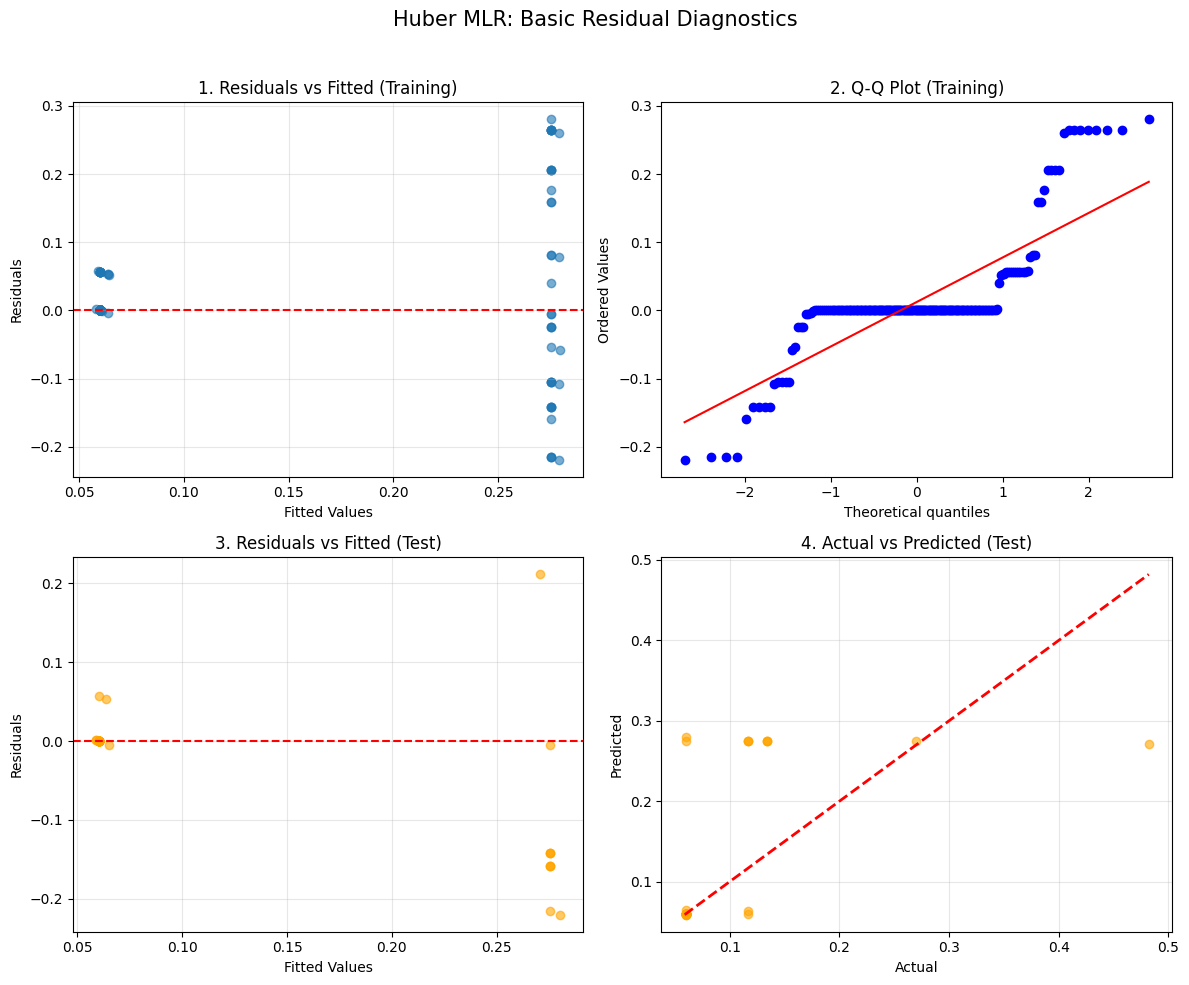


Top coefficients (by |value|):
                  feature   coefficient  abs_coefficient
             is_corrupted  8.709511e-02     8.709511e-02
               life_leech  8.599391e-04     8.599391e-04
                  quality -3.641551e-04     3.641551e-04
   highest_explicit_level  3.215241e-09     3.215241e-09
                     pdps -2.338799e-09     2.338799e-09
       implicit_mod_count -2.205406e-09     2.205406e-09
                     cdps -1.889124e-09     1.889124e-09
               mana_leech -1.867330e-09     1.867330e-09
      physical_damage_pct  1.713874e-09     1.713874e-09
                     ldps -1.692591e-09     1.692591e-09
         other_mods_count  1.392159e-09     1.392159e-09
     other_mods_avg_level  1.385869e-09     1.385869e-09
         attack_speed_pct -1.375686e-09     1.375686e-09
highest_explicit_tier_num -1.270172e-09     1.270172e-09
     other_mods_avg_value -1.197092e-09     1.197092e-09
     reduced_requirements  1.194059e-09     1.194059e-09

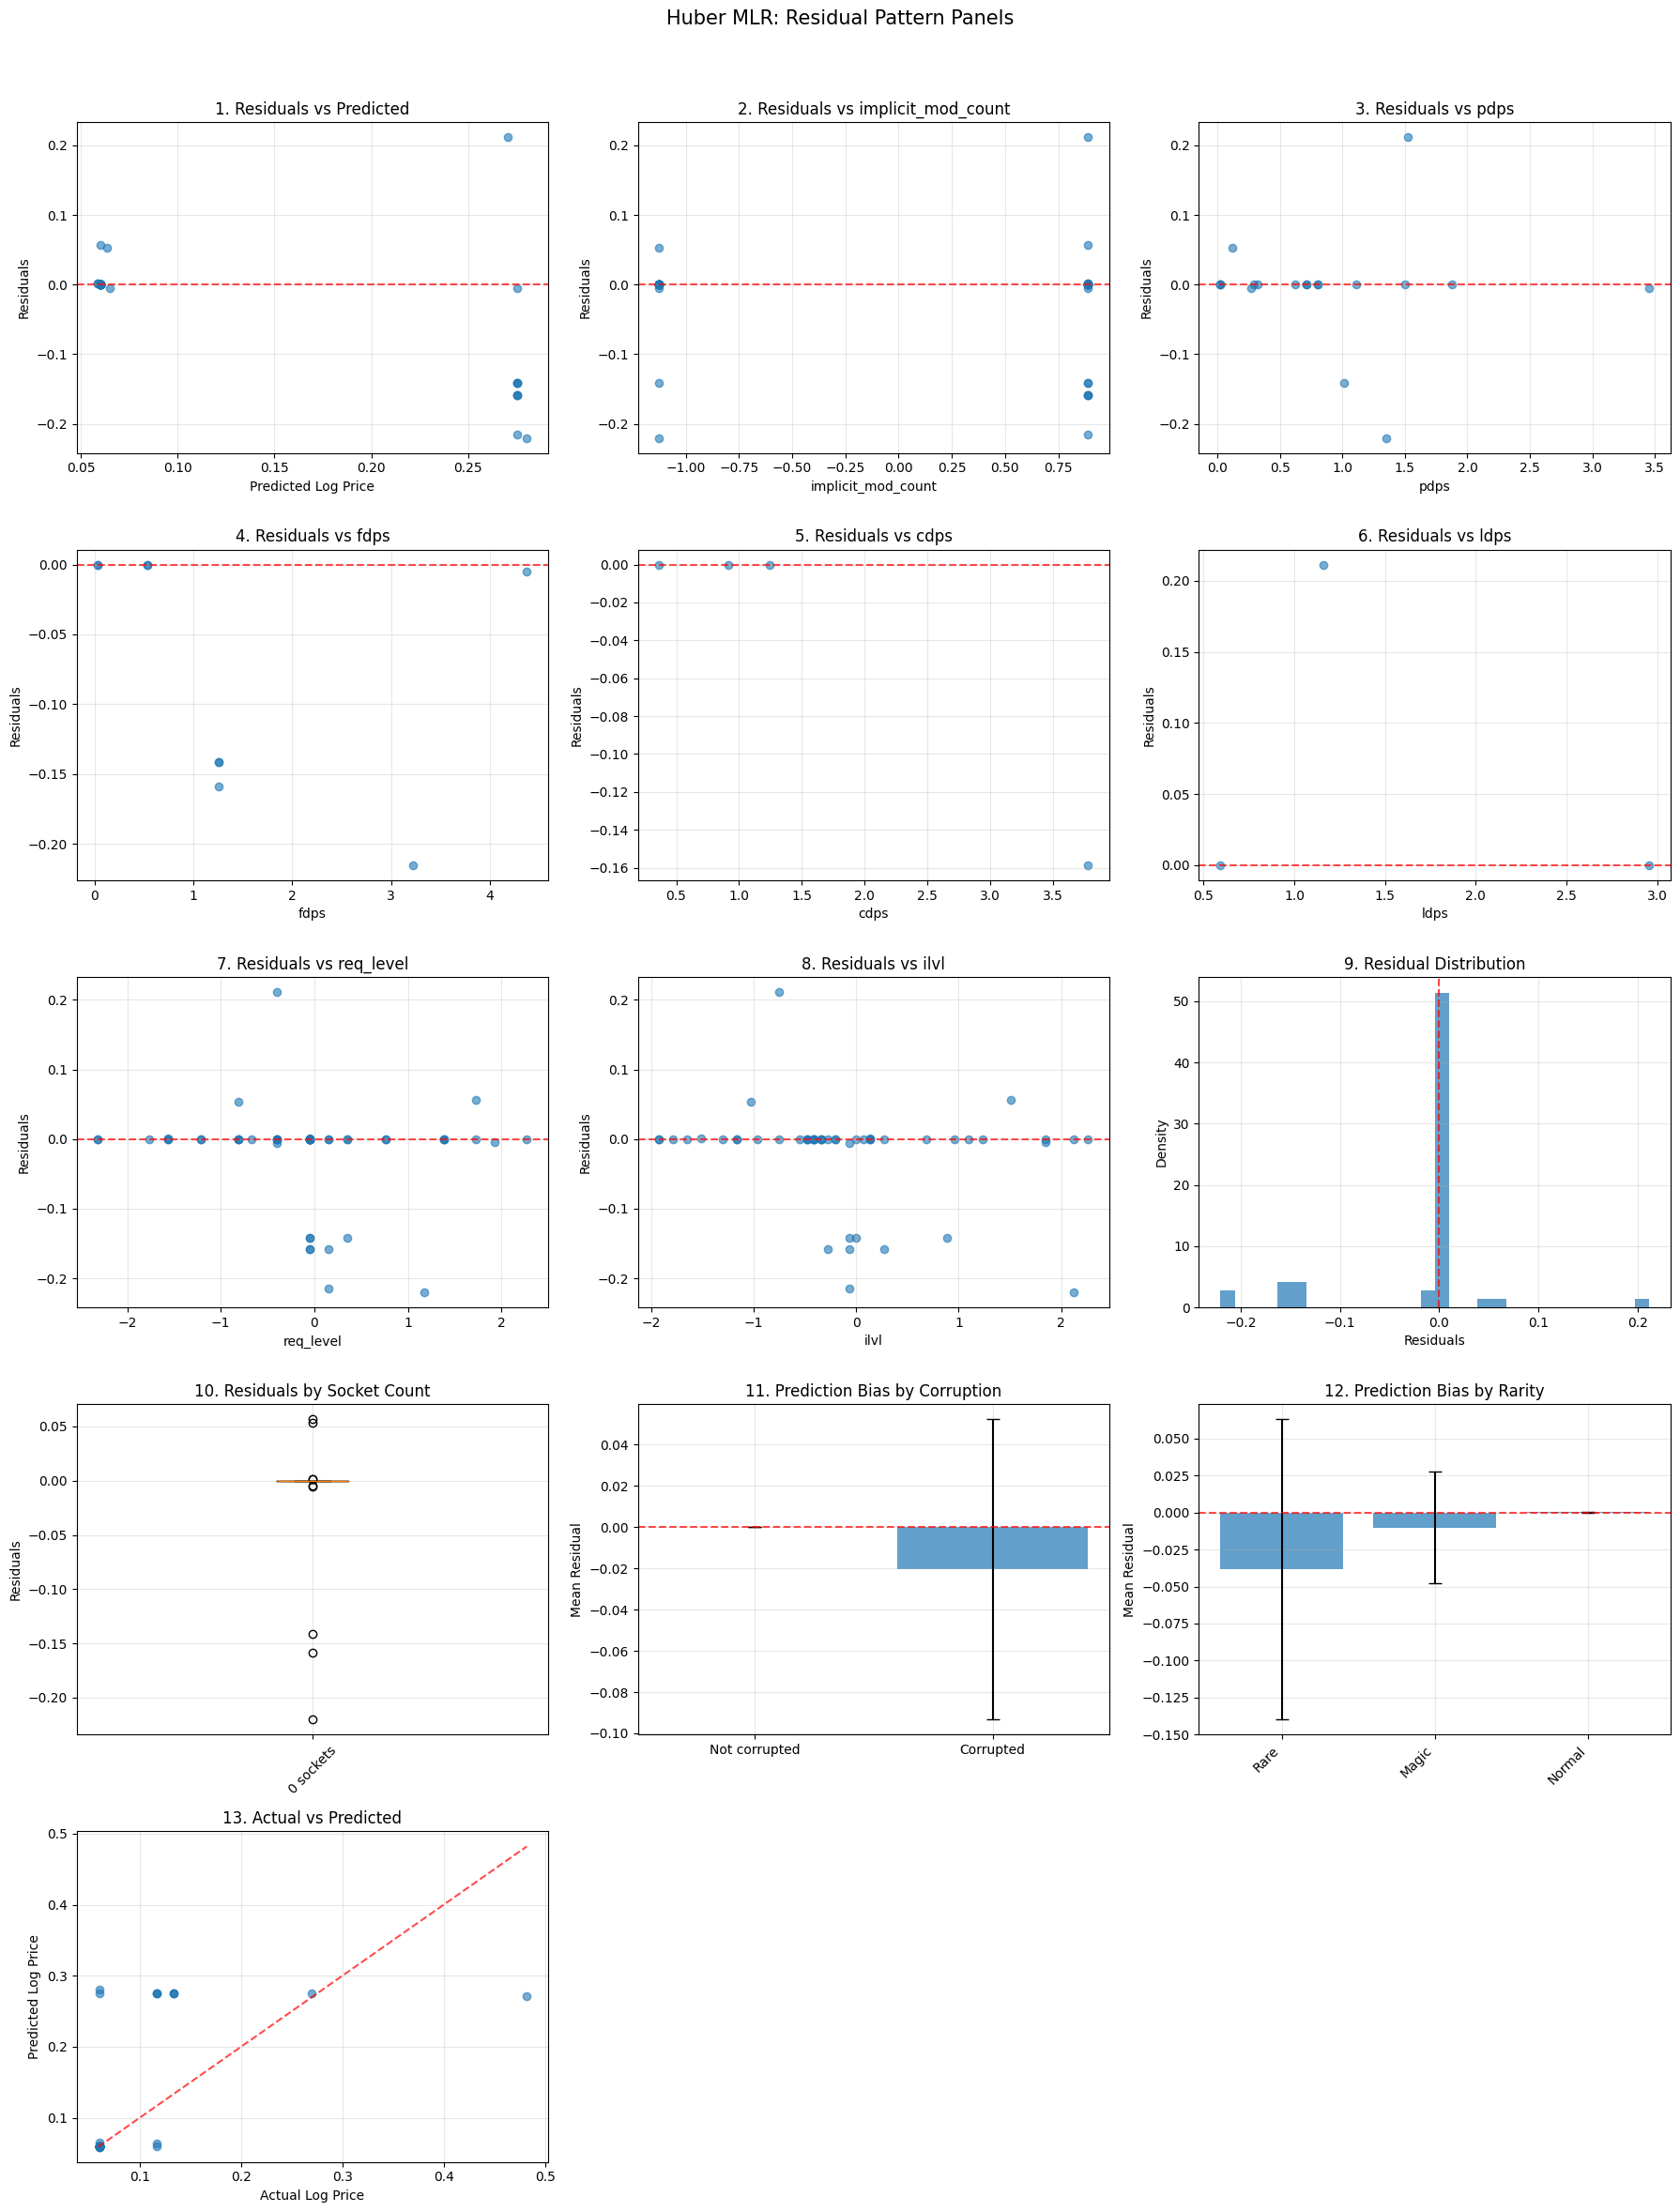

In [16]:
from modelling import run_huber, compare_regularized_models, run_xgb_shap, decompose_item_with_shap
out_huber = run_huber(X, y["log_price"], metadata=craft_meta, cv_splits=5, test_size=0.2, random_state=42)


=== Huber+Ridge (grid search, Pipeline) ===
Best params: {'huber__alpha': np.float64(0.08733261623828438)} | CV R² mean=0.5124 ± 0.0967
r2_train: 0.6025
r2_test: -0.2267
rmse_test: 0.0749
mae_test: 0.0333

Top coefficients (|value|):
               feature   coefficient  abs_coefficient
          is_corrupted  8.689439e-02     8.689439e-02
            life_leech  8.842984e-04     8.842984e-04
               quality -3.744705e-04     3.744705e-04
  other_mods_avg_level  6.863681e-09     6.863681e-09
    implicit_mod_count  5.420061e-09     5.420061e-09
  other_mods_avg_value -5.224786e-09     5.224786e-09
                  pdps  5.054986e-09     5.054986e-09
highest_explicit_level -3.470287e-09     3.470287e-09
             req_level -3.423919e-09     3.423919e-09
           skill_level -2.925593e-09     2.925593e-09
      increased_damage  2.655371e-09     2.655371e-09
                  ldps  2.580101e-09     2.580101e-09
                  fdps  2.521432e-09     2.521432e-09
         

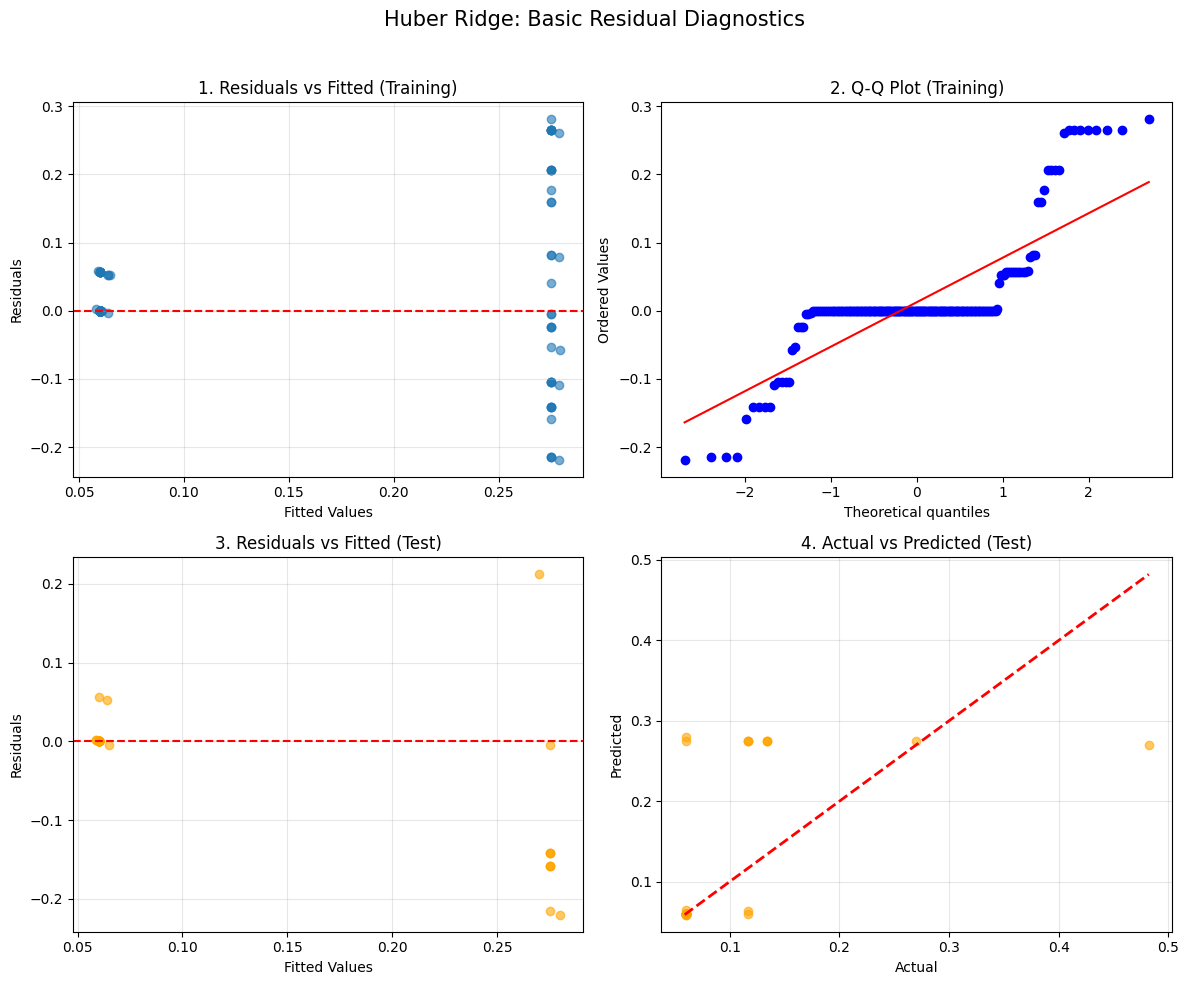

Huber Ridge PERFORMANCE DIAGNOSTICS
Overall Test R²: -0.2267
Mean Absolute Error: 0.0333
Root Mean Squared Error: 0.0749


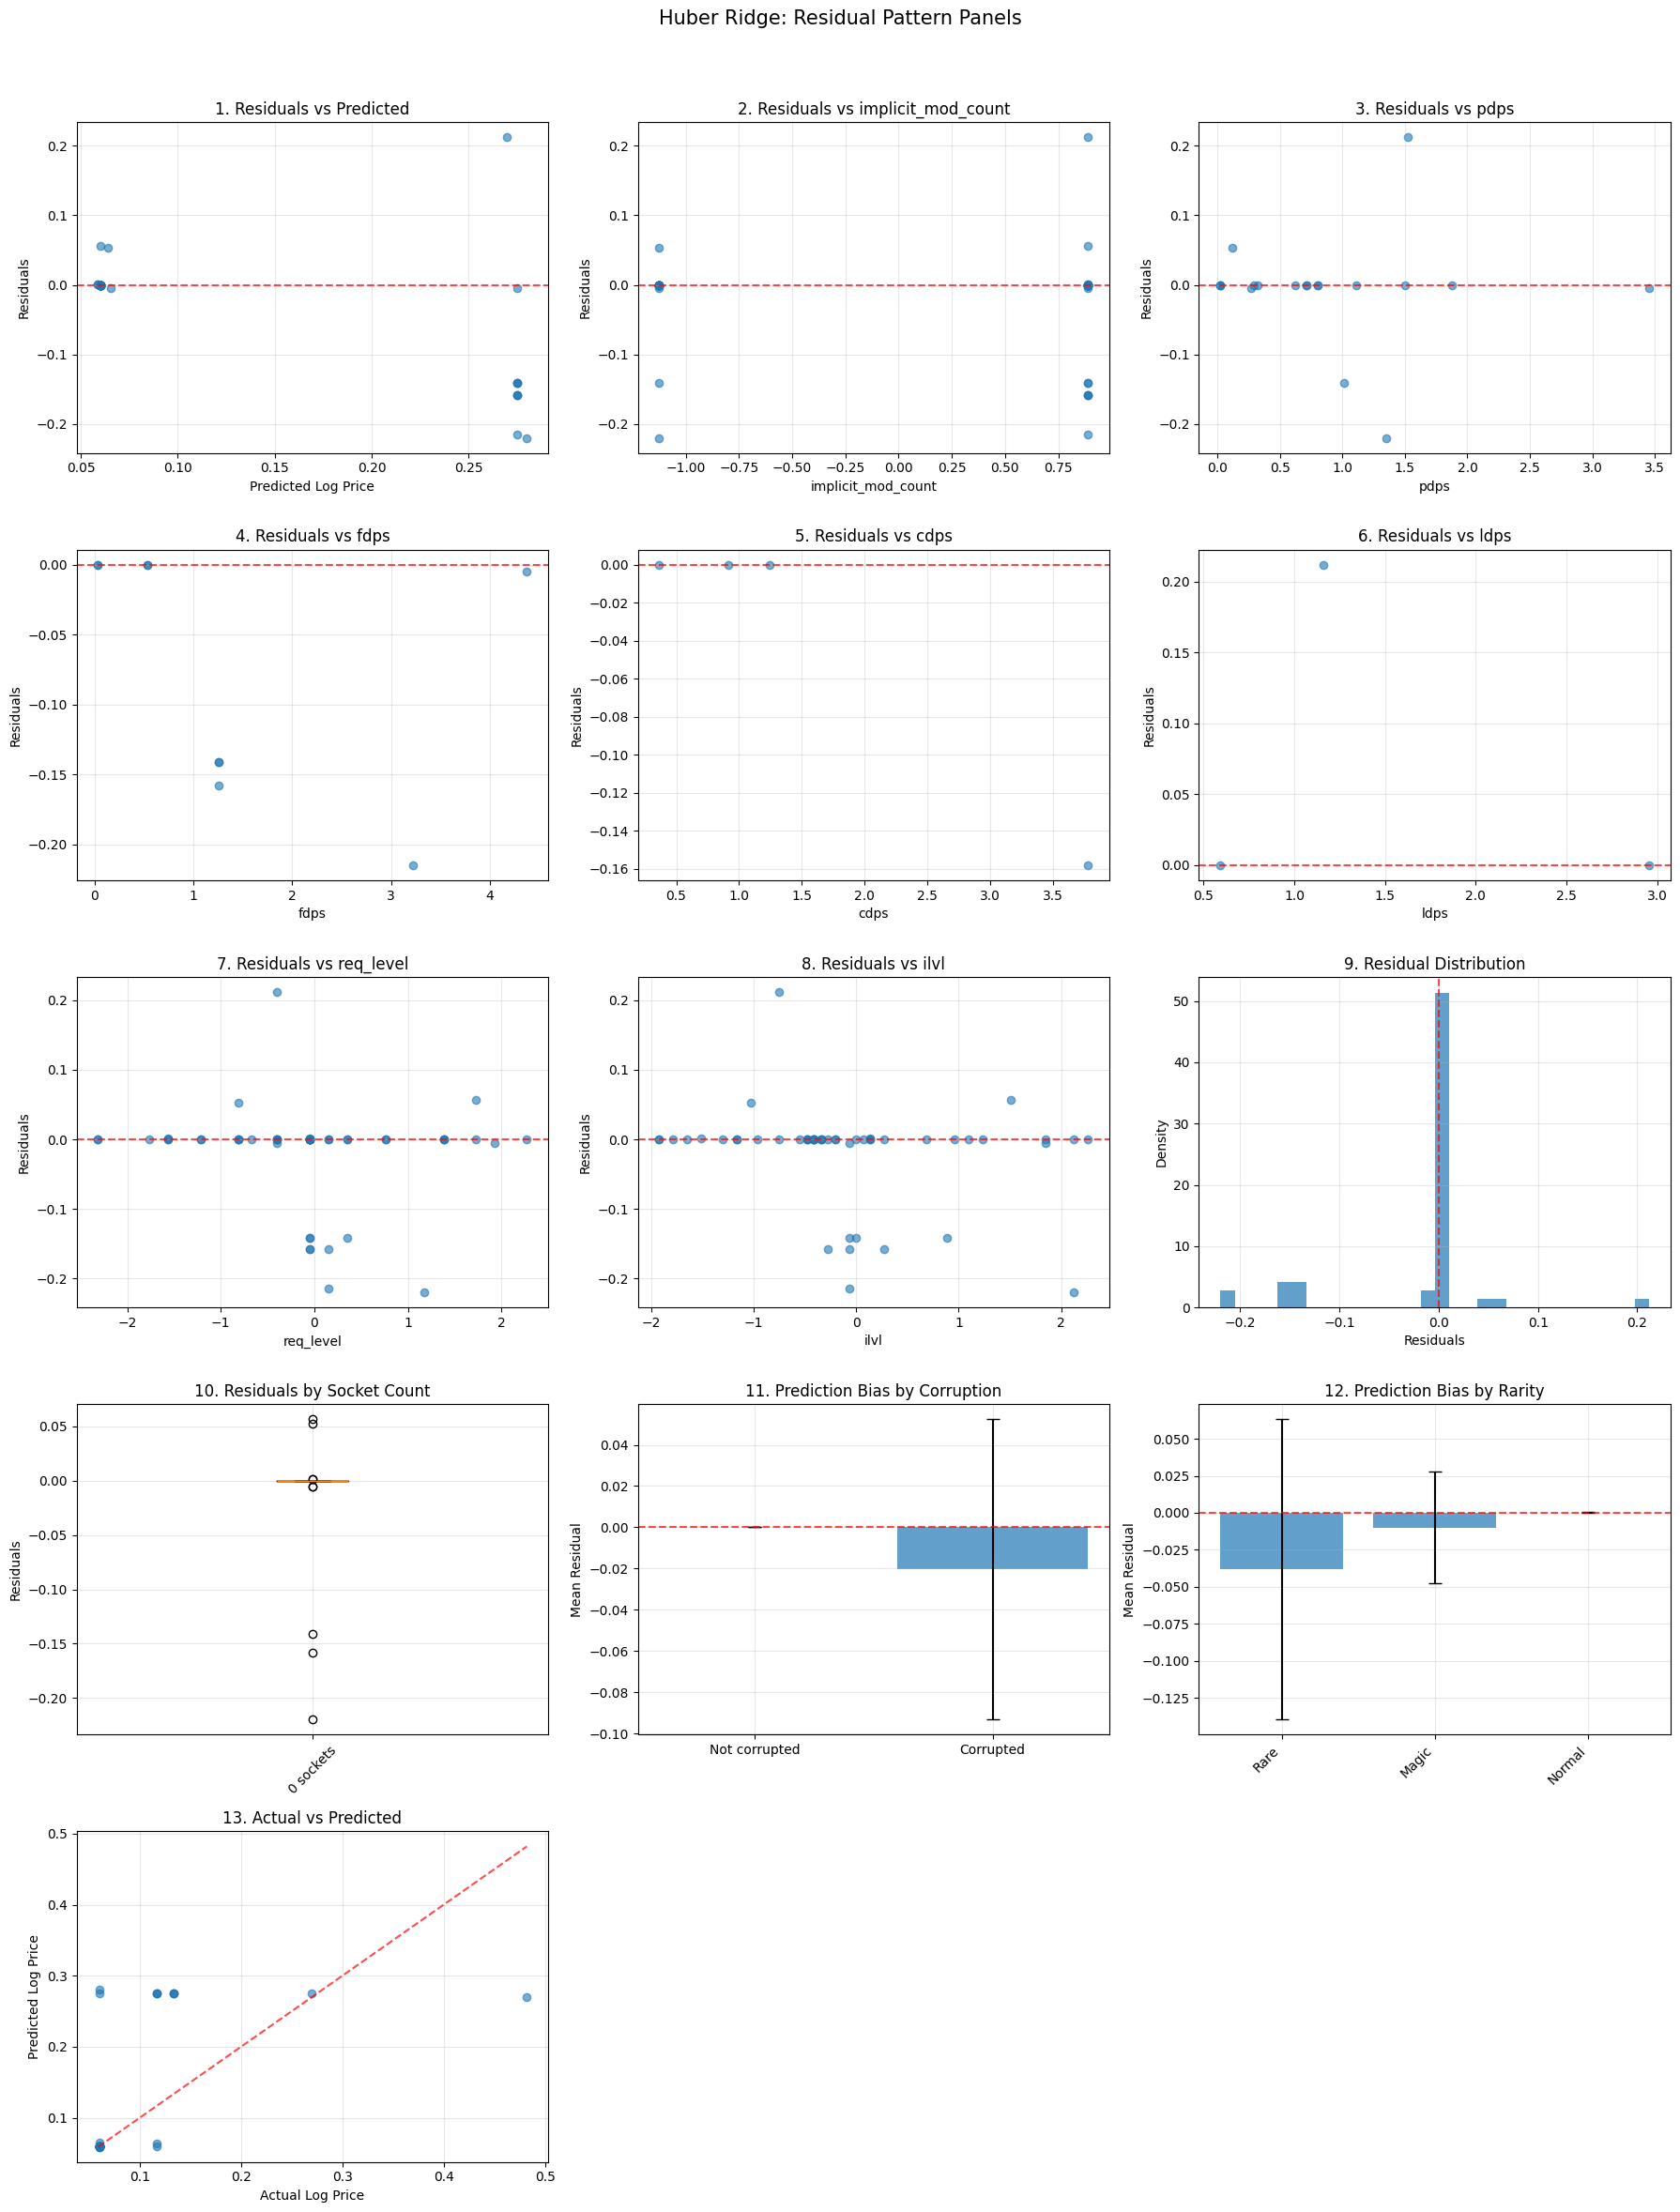


=== Huber+ElasticNet (grid search, Pipeline) ===
Best params: {'sgd__alpha': np.float64(0.01), 'sgd__l1_ratio': 0.7} | CV R² mean=0.5223 ± 0.1017
r2_train: 0.6099
r2_test: -0.0361
rmse_test: 0.0688
mae_test: 0.0371

Non-zero coefficients: 2/28

Top coefficients (|value|):
                  feature  coefficient  abs_coefficient
             is_corrupted     0.081703         0.081703
      physical_damage_pct     0.013029         0.013029
                     ilvl     0.000000         0.000000
                     ldps     0.000000         0.000000
     reduced_requirements     0.000000         0.000000
             life_on_kill     0.000000         0.000000
             light_radius     0.000000         0.000000
                dexterity     0.000000         0.000000
         attack_speed_pct     0.000000         0.000000
          accuracy_rating     0.000000         0.000000
         increased_damage     0.000000         0.000000
               life_leech     0.000000         0.00000

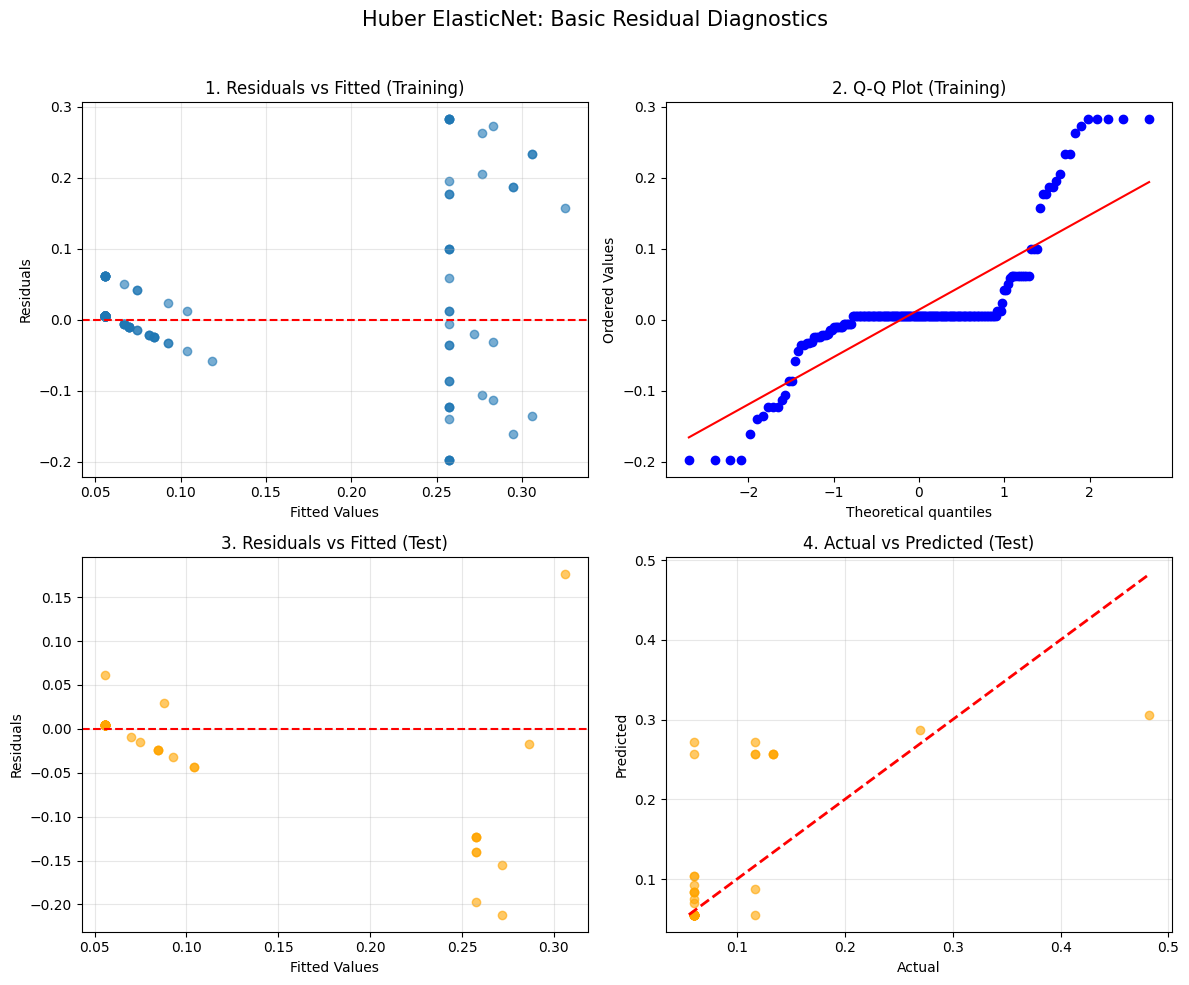

Huber ElasticNet PERFORMANCE DIAGNOSTICS
Overall Test R²: -0.0361
Mean Absolute Error: 0.0371
Root Mean Squared Error: 0.0688


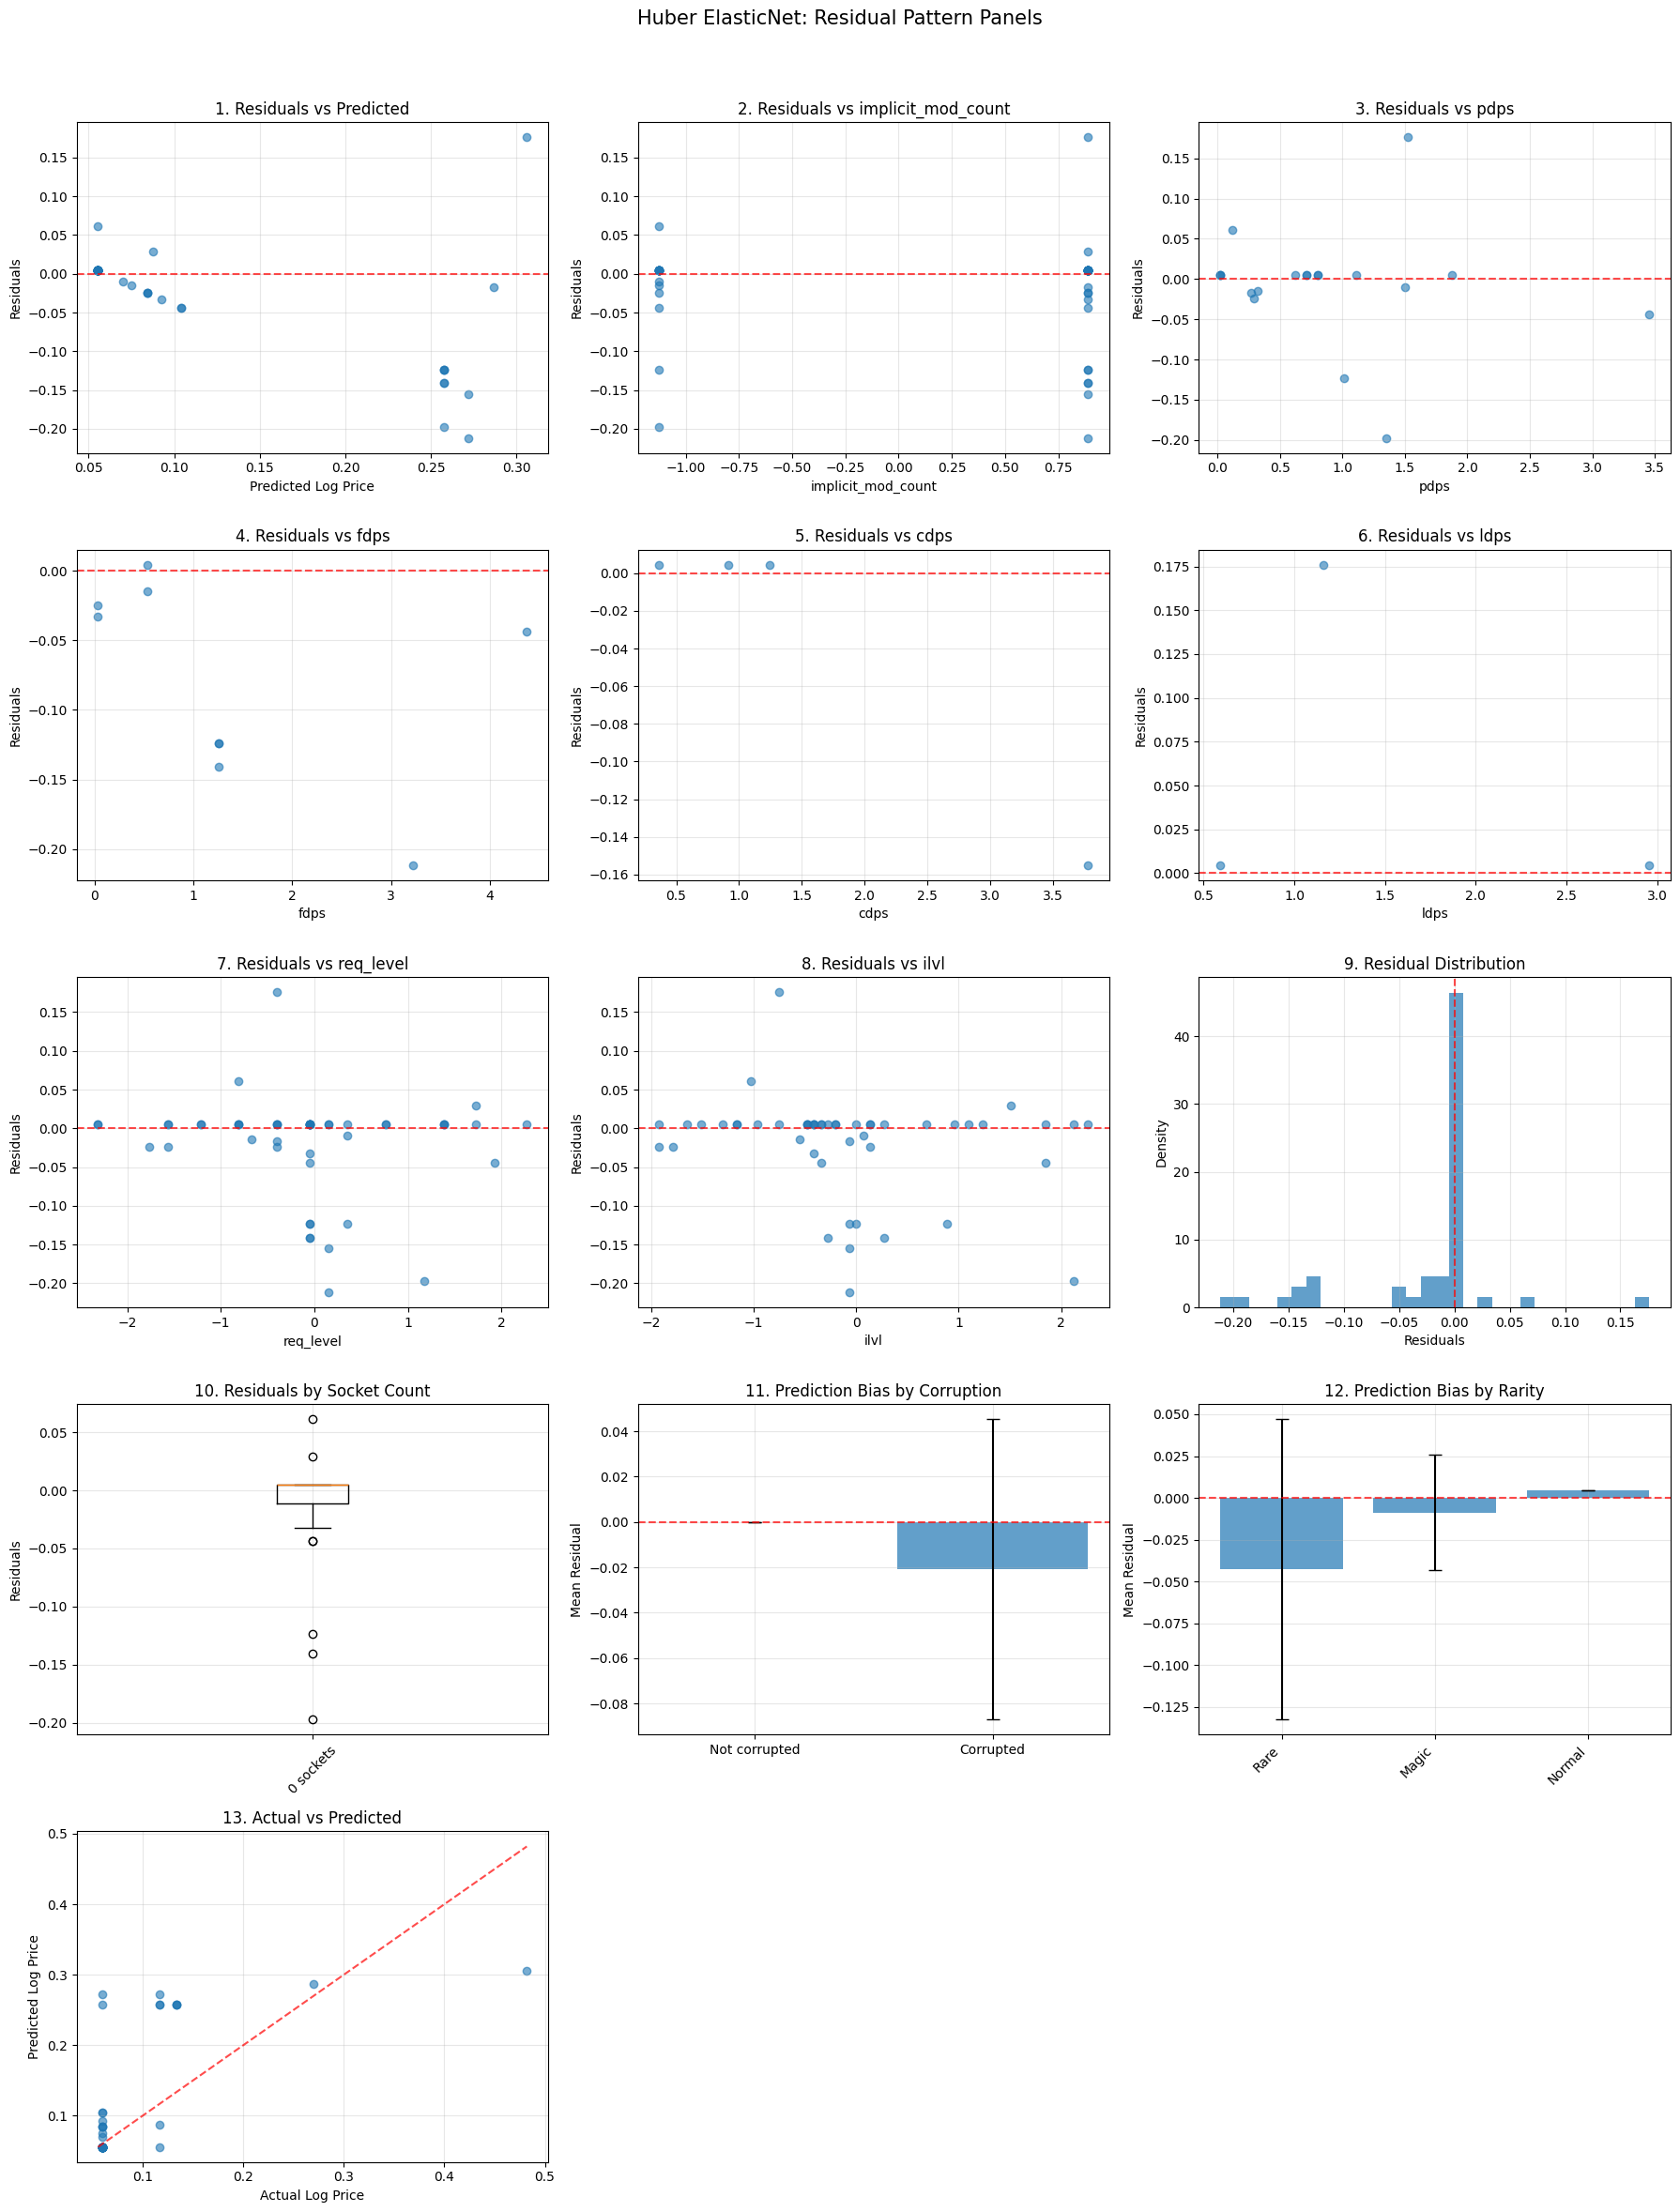


=== Regularized Models (Huber, Pipelines): Comparison ===
          model  best_alpha  best_l1_ratio  cv_mean_r2  cv_std_r2  test_r2  test_rmse  test_mae
     HuberRidge      0.0873            NaN      0.5124     0.0967  -0.2267     0.0749    0.0333
HuberElasticNet      0.0100         0.7000      0.5223     0.1017  -0.0361     0.0688    0.0371


In [15]:
cmp = compare_regularized_models(
    X, y["log_price"], metadata=craft_meta,
    ridge_alphas=np.logspace(-6, 1, 18),
    en_alphas=np.logspace(-6, -2, 10),
    en_l1_ratios=[0.05, 0.15, 0.3, 0.5, 0.7, 0.85, 0.95],
    cv_splits=5, test_size=0.2, random_state=42, n_jobs=-1, epsilon=1.35, plots=True
)


=== XGBoost (GridSearchCV on TRAIN) ===
Best params: {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 10.0, 'subsample': 0.7} | CV R² mean=0.5181 ± 0.1015
R² train=0.7676 | test=-1.4275  RMSE test=0.1053  MAE test=0.0528


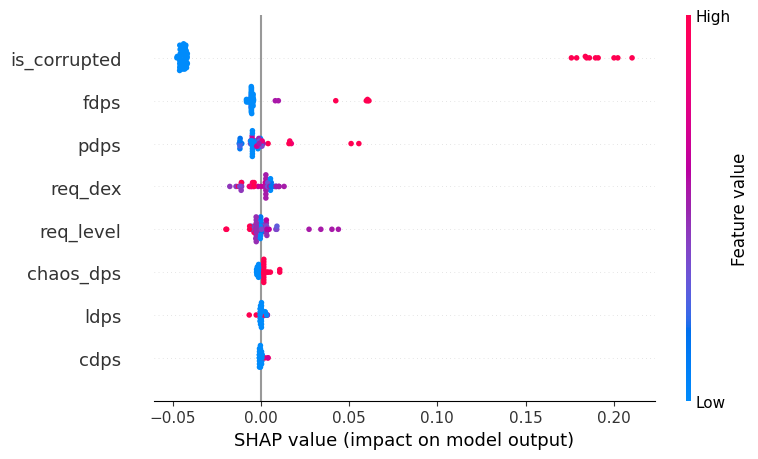

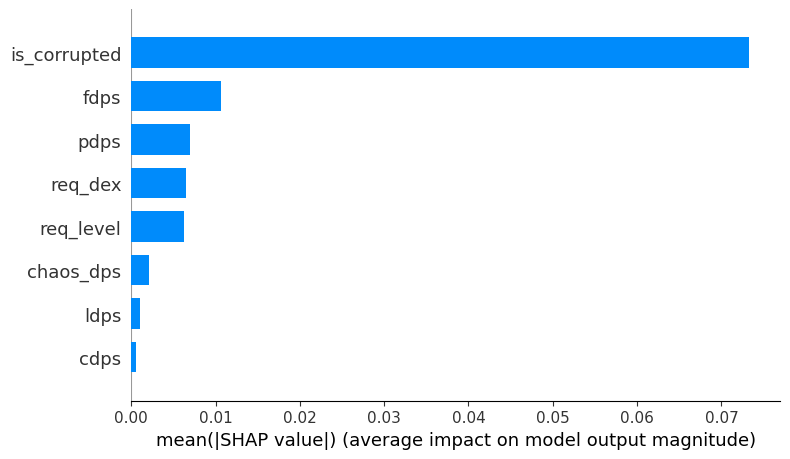

LINEAR REGRESSION PERFORMANCE DIAGNOSTICS
Overall Test R²: -1.4275
Mean Absolute Error: 0.0528
Root Mean Squared Error: 0.1053


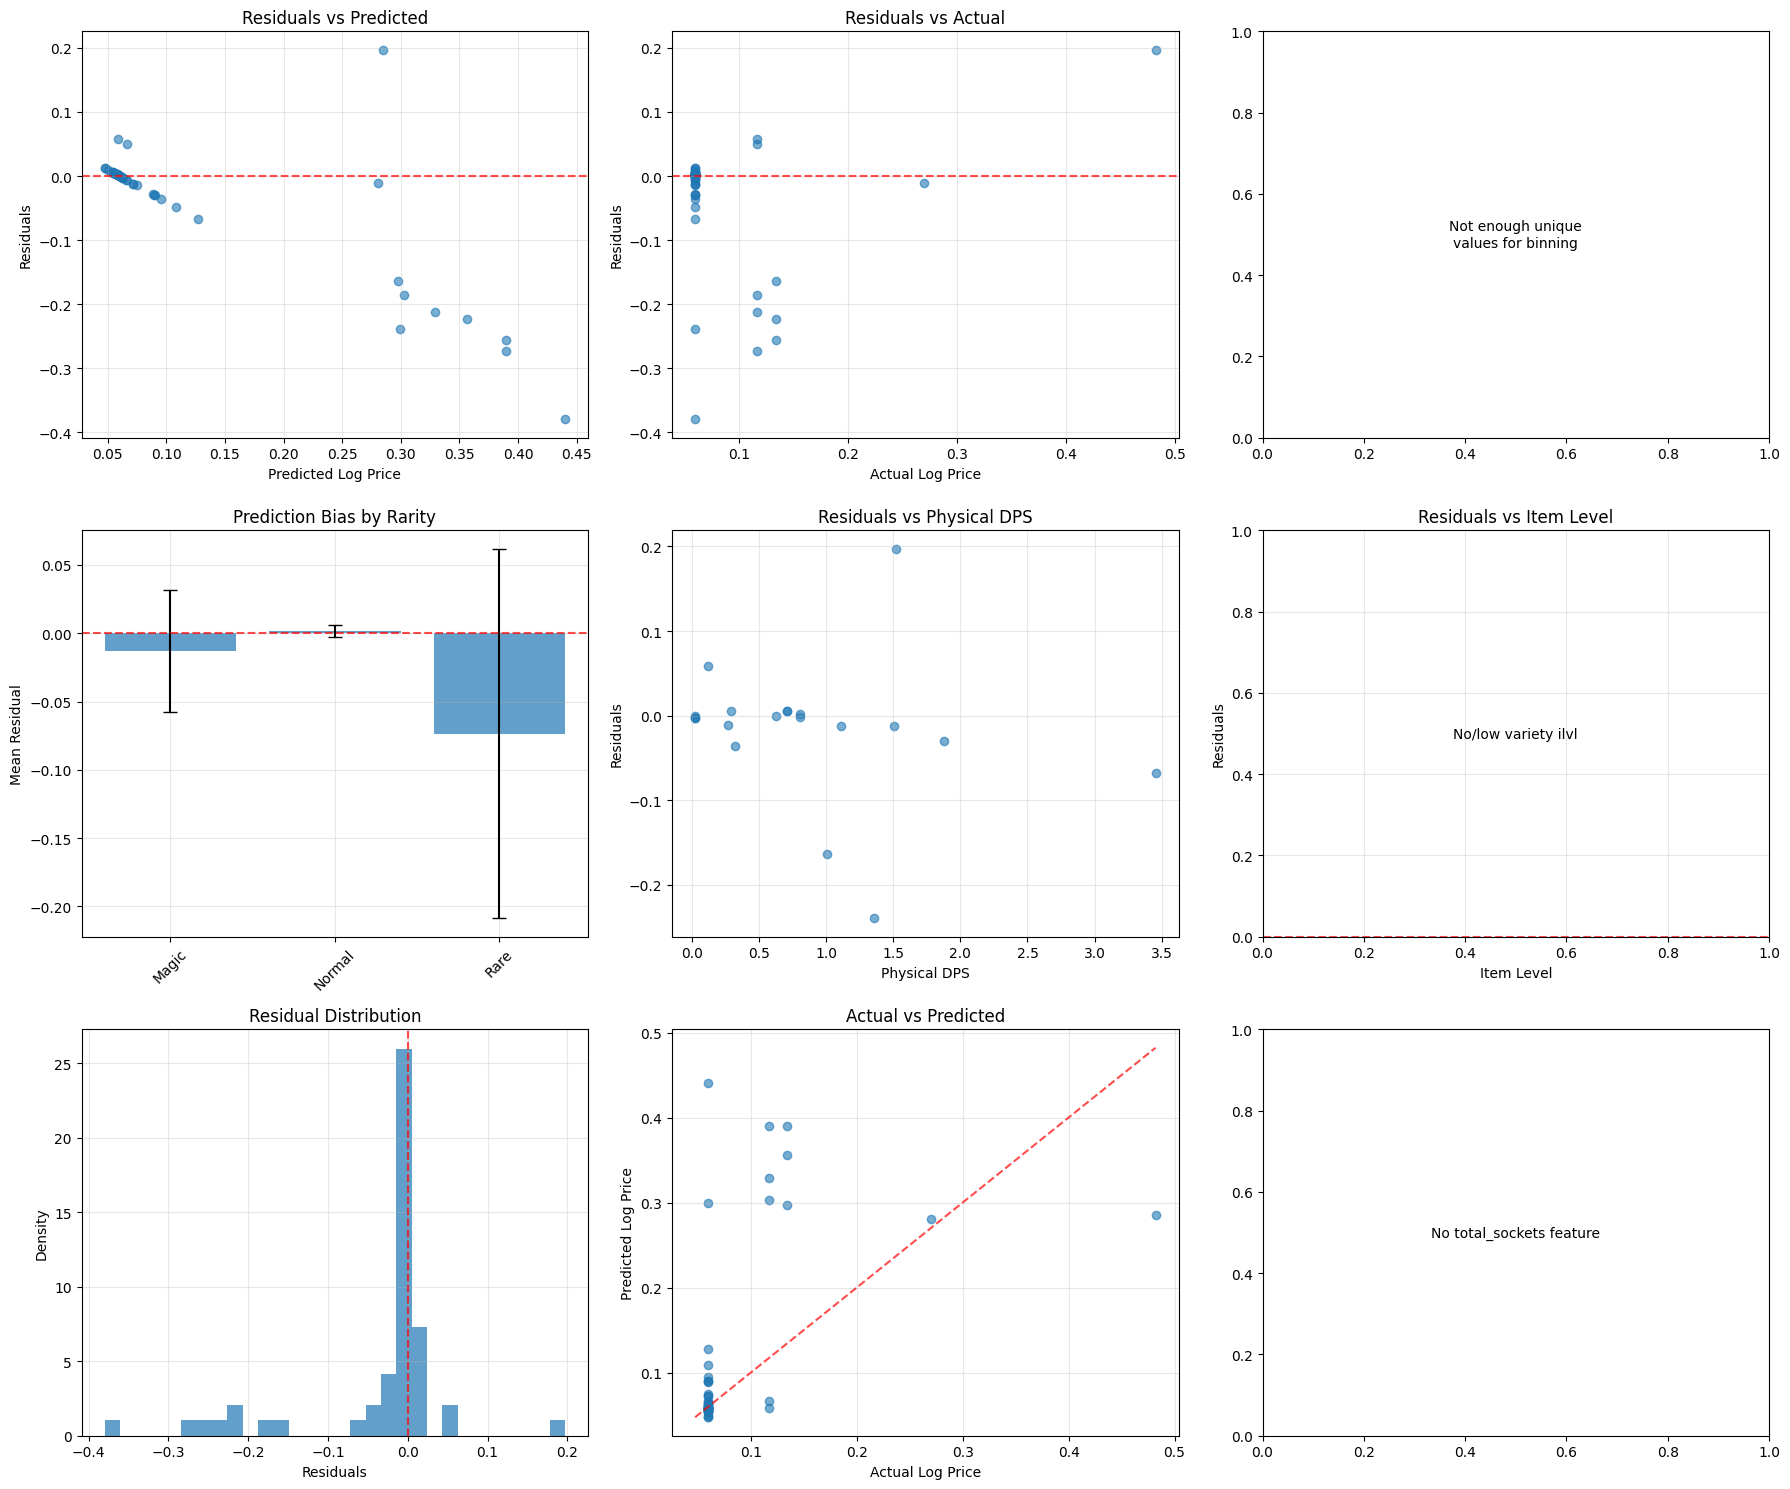

Squared error: {'model': 'XGBRegressor (GridSearchCV)', 'best_params': {'colsample_bytree': 0.7, 'learning_rate': 0.03, 'max_depth': 4, 'min_child_weight': 5, 'n_estimators': 400, 'reg_alpha': 0.1, 'reg_lambda': 10.0, 'subsample': 0.7}, 'cv_mean_r2': 0.5180510245931689, 'cv_std_r2': 0.10151480885424317, 'r2_train': 0.7675585975421595, 'r2_test': -1.427453117875325, 'rmse_train': 0.062096045671411, 'rmse_test': 0.10534353845206802, 'mae_train': 0.0329065595024434, 'mae_test': 0.05281128540037595}


In [ ]:
xgb_out = run_xgb_shap(
    X, y["log_price"], metadata=craft_meta,
    base_params=dict(
        tree_method="hist",
        objective="reg:pseudohubererror", # robust loss
        # objective="reg:squarederror", # more overfitting
        random_state=42
    ),
    param_grid=None,
    cv_splits=5, test_size=0.2, random_state=42, n_jobs=-1,
    plots=True, shap_sample=3000
)

print("Squared error:", xgb_out["metrics"])

In [ ]:
import shap
model = xgb_out.get("best_model", xgb_out.get("model"))
explainer = shap.TreeExplainer(model)

# pick a test item to explain
row = xgb_out["X_test"].iloc[0]

row_table, row_summary = decompose_item_with_shap(model, explainer, row)

print("Summary:", row_summary.to_dict(orient="records")[0])
# Top contributing features (log-space φ and percent lift on (1+price))
display(
    row_table.loc[:, ["feature", "value", "phi_log", "lift_pct_(1+P)"]]
             .assign(lift_pct=lambda d: (d["lift_pct_(1+P)"]*100).round(2))
             .rename(columns={"lift_pct": "lift_pct_(1+P) [%]"})
)

Summary: {'baseline_log': 0.1166597530245781, 'pred_log': 0.08228828012943268, 'baseline_price': 0.12373701651572395, 'pred_price': 0.0857687702788722}


,feature,value,phi_log,lift_pct_(1+P),lift_pct_(1+P) [%]
11,physical_damage_pct,1.938655,0.014301,0.014403,1.44
24,log1p_highest_explicit_level,1.012317,0.009041,0.009082,0.91
20,log1p_ele_dps_sum,-0.789317,0.003560,0.003566,0.36
10,increased_damage,3.631240,0.002074,0.002076,0.21
16,life_on_kill,2.123451,0.001148,0.001149,0.11
3,other_mods_count,-0.815165,0.001105,0.001105,0.11
17,reduced_requirements,0.300526,0.000704,0.000704,0.07
4,highest_explicit_tier_num,-0.576651,0.000548,0.000548,0.05
13,attack_speed_pct,-0.346915,0.000367,0.000367,0.04
25,log1p_crit_chance,-0.340215,0.000351,0.000352,0.04


1. The Residuals vs. Fitted plot on the training and testing sets show that while there is no systematic bias (residuals seem to be centered at 0), the variance increases with fitted values, indicating heteroskedasticity in the dataset. Unless we apply significant data pre-processing, the Gauss-Markov assumption of homoskedasticity for linear models is violated.
2. The Q-Q plot shows that the middle quantiles seem to follow a normal distribution. However, the plot also show heavy tails, indicating deviation from normality at the extremes / tail ends of the data. 
3. The Actual vs. Predicted values plot on the test set shows a general trend along the diagonal line. However, the points show high variance at higher prices. This suggests a linear model is inadequate to model high prices / extreme values. 

1. The residuals distribution plot are somewhat bell-shaped and centered near zero. However, the right-tail suggests severe under-predictions. 
2. One hypothesis I had after observing these plots is that rarity may have a non-linear relationship with prices. By observing the mean residuals by rarity plot, we can see that the model performs worse for `rare` and `normal` type items. This suggests bias in the linear model by rarity, and this that this feature likely interacts non-linearly with prices. Furthermore, with the mean for each category being negative, the linear model underestimates prices. 

These results suggest that a non-parametric non-linear model may better fit the data to predict prices.



## Experimenting with Non-Linear Models

The previous analysis showed that linear models are a poor fit for data. I will try to model the data using non-linear models, namely GBM, XGBoost, Random Forest, and KNN. 

1. Gradient boosting models learn iteratively and try to correct the mistakes of the previous iterations. This approach might improve price predictions. 
2. KNN essentially predicts the price of an item by comparing it with comparable items in the dataset (akin to comparable valuation). If anything, this approach will be limited by a lack of training data.
3. Random forest will predict prices by following a series of decisions after inspecting each feature. In a game like POE2 where items have modifiers, rarities, and special effects, I believe that this model makes the most intuitive sense to me. 

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y['log_price'], test_size=0.2, random_state=42)

Training Gradient Boosting Regressor...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Training XGBoost...
Fitting 5 folds for each of 144 candidates, totalling 720 fits

Evaluating models on test set...
MODEL PERFORMANCE SUMMARY
  Model  CV R² Train R² Test R²      Full CV R² Test RMSE Train Time
    GBM 0.6532   0.7695  0.7106 0.6891 ± 0.0326    0.2241      14.8s
XGBoost 0.6716   0.7798  0.7255 0.7027 ± 0.0158    0.2183       9.9s

BEST HYPERPARAMETERS

GBM:
  learning_rate: 0.05
  max_depth: 3
  min_samples_leaf: 2
  min_samples_split: 5
  n_estimators: 100

XGBoost:
  colsample_bytree: 0.8
  learning_rate: 0.05
  max_depth: 3
  min_child_weight: 1
  n_estimators: 100
  subsample: 1.0


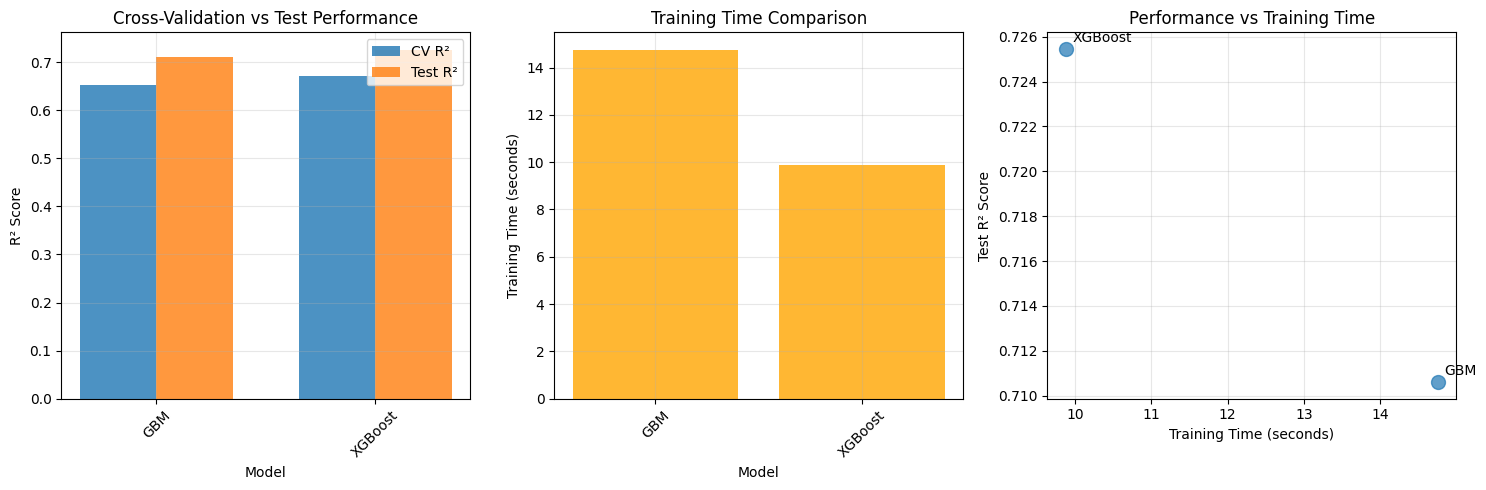

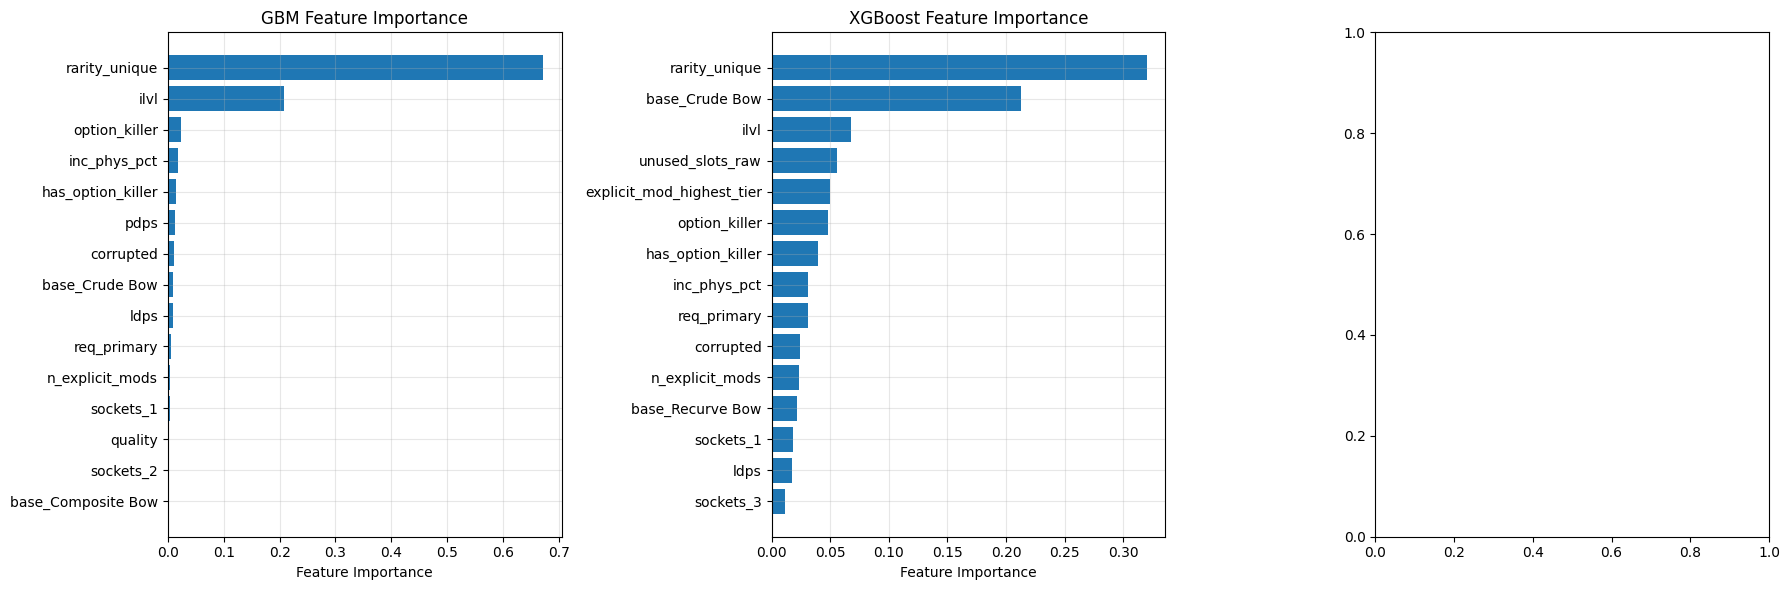


Best performing model: XGBoost
Test R²: 0.7255


In [ ]:
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import time

def train_and_evaluate_models(X_train, X_test, y_train, y_test, cv=5):
    """
    Train and evaluate non-linear models with hyperparameter tuning.
    """
    results = {}
    
    # 1. GRADIENT BOOSTING MACHINE
    print("Training Gradient Boosting Regressor...")
    start_time = time.time()
    
    gbm_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    gbm = GradientBoostingRegressor(random_state=42)
    gbm_grid = GridSearchCV(gbm, gbm_params, cv=cv, scoring='r2', n_jobs=-1, verbose=1)
    gbm_grid.fit(X_train, y_train)
    
    gbm_time = time.time() - start_time
    results['GBM'] = {
        'model': gbm_grid.best_estimator_,
        'best_params': gbm_grid.best_params_,
        'cv_score': gbm_grid.best_score_,
        'train_time': gbm_time
    }
    
    # 2. XGBOOST
    print("Training XGBoost...")
    start_time = time.time()
    
    xgb_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_child_weight': [1, 3],
        'subsample': [0.8, 1.0],
        'colsample_bytree': [0.8, 1.0]
    }
    
    xgb_model = xgb.XGBRegressor(random_state=42, tree_method='hist')
    xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=cv, scoring='r2', n_jobs=-1, verbose=1)
    xgb_grid.fit(X_train, y_train)
    
    xgb_time = time.time() - start_time
    results['XGBoost'] = {
        'model': xgb_grid.best_estimator_,
        'best_params': xgb_grid.best_params_,
        'cv_score': xgb_grid.best_score_,
        'train_time': xgb_time
    }
    
    # EVALUATE ALL MODELS
    print("\nEvaluating models on test set...")
    for name, result in results.items():
        model = result['model']
        
        # Test set predictions
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        
        # Calculate metrics
        result['train_r2'] = r2_score(y_train, y_pred_train)
        result['test_r2'] = r2_score(y_test, y_pred_test)
        result['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        # Additional cross-validation on full dataset for robust estimate
        full_cv_scores = cross_val_score(model, 
                                       pd.concat([X_train, X_test]), 
                                       pd.concat([y_train, y_test]), 
                                       cv=cv, scoring='r2')
        result['full_cv_mean'] = full_cv_scores.mean()
        result['full_cv_std'] = full_cv_scores.std()
    
    return results

def plot_model_comparison(results):
    """Plot model performance comparison."""
    # Extract metrics for comparison
    models = list(results.keys())
    cv_scores = [results[m]['cv_score'] for m in models]
    test_scores = [results[m]['test_r2'] for m in models]
    train_times = [results[m]['train_time'] for m in models]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # CV vs Test R²
    x = np.arange(len(models))
    width = 0.35
    
    axes[0].bar(x - width/2, cv_scores, width, label='CV R²', alpha=0.8)
    axes[0].bar(x + width/2, test_scores, width, label='Test R²', alpha=0.8)
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('R² Score')
    axes[0].set_title('Cross-Validation vs Test Performance')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Training time
    axes[1].bar(models, train_times, alpha=0.8, color='orange')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Training Time (seconds)')
    axes[1].set_title('Training Time Comparison')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    # Performance vs Time scatter
    axes[2].scatter(train_times, test_scores, s=100, alpha=0.7)
    for i, model in enumerate(models):
        axes[2].annotate(model, (train_times[i], test_scores[i]), 
                        xytext=(5, 5), textcoords='offset points')
    axes[2].set_xlabel('Training Time (seconds)')
    axes[2].set_ylabel('Test R² Score')
    axes[2].set_title('Performance vs Training Time')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(results, feature_names, top_k=15):
    """Plot feature importance for tree-based models."""
    tree_models = ['GBM', 'XGBoost', 'Random Forest']
    
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    for i, model_name in enumerate(tree_models):
        if model_name in results:
            model = results[model_name]['model']
            
            # Get feature importance
            if hasattr(model, 'feature_importances_'):
                importance = model.feature_importances_
                
                # Create importance dataframe
                imp_df = pd.DataFrame({
                    'feature': feature_names,
                    'importance': importance
                }).sort_values('importance', ascending=False).head(top_k)
                
                # Plot
                axes[i].barh(range(len(imp_df)), imp_df['importance'])
                axes[i].set_yticks(range(len(imp_df)))
                axes[i].set_yticklabels(imp_df['feature'])
                axes[i].set_xlabel('Feature Importance')
                axes[i].set_title(f'{model_name} Feature Importance')
                axes[i].grid(True, alpha=0.3)
                
                # Invert y-axis to show most important at top
                axes[i].invert_yaxis()
    
    plt.tight_layout()
    plt.show()

def print_detailed_results(results):
    """Print comprehensive model results."""
    print("=" * 80)
    print("MODEL PERFORMANCE SUMMARY")
    print("=" * 80)
    
    # Create summary table
    summary_data = []
    for name, result in results.items():
        summary_data.append({
            'Model': name,
            'CV R²': f"{result['cv_score']:.4f}",
            'Train R²': f"{result['train_r2']:.4f}",
            'Test R²': f"{result['test_r2']:.4f}",
            'Full CV R²': f"{result['full_cv_mean']:.4f} ± {result['full_cv_std']:.4f}",
            'Test RMSE': f"{result['test_rmse']:.4f}",
            'Train Time': f"{result['train_time']:.1f}s"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("BEST HYPERPARAMETERS")
    print("=" * 80)
    
    for name, result in results.items():
        print(f"\n{name}:")
        for param, value in result['best_params'].items():
            print(f"  {param}: {value}")

# Train all models
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Print results
print_detailed_results(results)

# Plot comparisons
plot_model_comparison(results)

# Plot feature importance (for tree-based models)
plot_feature_importance(results, X_train.columns)

# Find best model
best_model_name = max(results.keys(), key=lambda k: results[k]['test_r2'])
best_model = results[best_model_name]['model']

print(f"\nBest performing model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")

In [ ]:
import lightgbm as lgb
from catboost import CatBoostRegressor
from sklearn.ensemble import ExtraTreesRegressor, VotingRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import r2_score, mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

def train_and_evaluate_models(X_train, X_test, y_train, y_test, cv=5):
    """
    Train and evaluate all models with balanced hyperparameter grids (5-10 min target).
    """
    # Handle DataFrame targets
    if hasattr(y_train, 'columns'):
        y_train = y_train['log_price'] if 'log_price' in y_train.columns else y_train.iloc[:, -1]
    if hasattr(y_test, 'columns'):
        y_test = y_test['log_price'] if 'log_price' in y_test.columns else y_test.iloc[:, -1]
    
    results = {}
    
    # 1. GRADIENT BOOSTING MACHINE (360 fits)
    print("Training Gradient Boosting Regressor...")
    start_time = time.time()
    
    gbm_params = {
        'n_estimators': [100, 200],
        'learning_rate': [0.05, 0.1, 0.2],
        'max_depth': [3, 5, 7],
        'min_samples_split': [2, 5],
        'min_samples_leaf': [1, 2]
    }
    
    gbm = GradientBoostingRegressor(random_state=42)
    gbm_grid = GridSearchCV(gbm, gbm_params, cv=cv, scoring='r2', n_jobs=-1, verbose=1)
    gbm_grid.fit(X_train, y_train)
    
    gbm_time = time.time() - start_time
    results['GBM'] = {
        'model': gbm_grid.best_estimator_,
        'best_params': gbm_grid.best_params_,
        'cv_score': gbm_grid.best_score_,
        'train_time': gbm_time
    }
    
    # 2. XGBOOST (1,152 fits - reduced from 51,840)
    print("Training XGBoost...")
    start_time = time.time()
    
    xgb_params = {
        'n_estimators': [200, 300],              # Reduced from [100, 200, 300]
        'learning_rate': [0.05, 0.1, 0.15],     # Reduced from [0.05, 0.1, 0.15, 0.2]
        'max_depth': [5, 7, 9],                 # Reduced from [3, 5, 7, 9]
        'min_child_weight': [1, 3],             # Reduced from [1, 3, 5]
        'subsample': [0.8, 1.0],                # Reduced from [0.7, 0.8, 0.9, 1.0]
        'colsample_bytree': [0.8, 1.0],         # Reduced from [0.7, 0.8, 0.9, 1.0]
        'reg_alpha': [0, 0.1],                  # Reduced from [0, 0.1, 1]
        'reg_lambda': [0.5, 1]                  # Reduced from [0.5, 1, 1.5]
    }
    
    xgb_model = xgb.XGBRegressor(random_state=42, tree_method='hist')
    xgb_grid = GridSearchCV(xgb_model, xgb_params, cv=cv, scoring='r2', n_jobs=-1, verbose=1)
    xgb_grid.fit(X_train, y_train)
    
    xgb_time = time.time() - start_time
    results['XGBoost'] = {
        'model': xgb_grid.best_estimator_,
        'best_params': xgb_grid.best_params_,
        'cv_score': xgb_grid.best_score_,
        'train_time': xgb_time
    }
    
    # 3. RANDOM FOREST (144 fits - reduced from 12,800)
    print("Training Random Forest...")
    start_time = time.time()
    
    rf_params = {
        'n_estimators': [200, 300],             # Reduced from [100, 200, 300, 500]
        'max_depth': [10, 15, 20, None],        # Reduced from [5, 10, 15, 20, None]
        'min_samples_split': [2, 5, 10],        # Reduced from [2, 5, 10, 20]
        'min_samples_leaf': [1, 2, 4],          # Reduced from [1, 2, 4, 8]
        'max_features': ['sqrt', 'log2']        # Reduced from ['sqrt', 'log2', 0.5, 0.8]
    }
    
    rf = RandomForestRegressor(random_state=42, n_jobs=-1)
    rf_grid = GridSearchCV(rf, rf_params, cv=cv, scoring='r2', n_jobs=-1, verbose=1)
    rf_grid.fit(X_train, y_train)
    
    rf_time = time.time() - start_time
    results['Random Forest'] = {
        'model': rf_grid.best_estimator_,
        'best_params': rf_grid.best_params_,
        'cv_score': rf_grid.best_score_,
        'train_time': rf_time
    }
    
    # 4. LIGHTGBM (128 fits - reduced from 983,040!)
    print("Training LightGBM...")
    start_time = time.time()
    
    lgb_params = {
        'n_estimators': [200, 300],             # Reduced from [100, 200, 300, 500]
        'learning_rate': [0.1, 0.15],           # Reduced from [0.05, 0.1, 0.15, 0.2]
        'max_depth': [5, 7],                    # Reduced from [3, 5, 7, 10]
        'num_leaves': [31, 50],                 # Reduced from [20, 31, 50, 100]
        'min_child_samples': [10, 20],          # Reduced from [5, 10, 20, 30]
        'subsample': [0.8, 1.0],               # Reduced from [0.7, 0.8, 0.9, 1.0]
        'colsample_bytree': [0.8, 1.0]         # Reduced from [0.7, 0.8, 0.9, 1.0]
    }
    
    lgb_model = lgb.LGBMRegressor(random_state=42, verbose=-1)
    lgb_grid = GridSearchCV(lgb_model, lgb_params, cv=cv, scoring='r2', n_jobs=-1, verbose=1)
    lgb_grid.fit(X_train, y_train)
    
    lgb_time = time.time() - start_time
    results['LightGBM'] = {
        'model': lgb_grid.best_estimator_,
        'best_params': lgb_grid.best_params_,
        'cv_score': lgb_grid.best_score_,
        'train_time': lgb_time
    }
    
    # 5. CATBOOST (54 fits - reduced from 27,000)
    print("Training CatBoost...")
    start_time = time.time()
    
    cat_params = {
        'iterations': [200, 300],               # Reduced from [100, 200, 300, 500]
        'learning_rate': [0.05, 0.1, 0.15],    # Reduced from [0.03, 0.05, 0.1, 0.15, 0.2]
        'depth': [5, 6, 7],                     # Reduced from [4, 5, 6, 7, 8, 9]
        'l2_leaf_reg': [1, 3, 5]               # Reduced from [1, 3, 5, 10, 15]
    }
    
    cat_model = CatBoostRegressor(random_state=42, verbose=False)
    cat_grid = GridSearchCV(cat_model, cat_params, cv=cv, scoring='r2', n_jobs=-1, verbose=1)
    cat_grid.fit(X_train, y_train)
    
    cat_time = time.time() - start_time
    results['CatBoost'] = {
        'model': cat_grid.best_estimator_,
        'best_params': cat_grid.best_params_,
        'cv_score': cat_grid.best_score_,
        'train_time': cat_time
    }
    
    # 6. EXTRA TREES (144 fits - reduced from 12,800)
    print("Training Extra Trees...")
    start_time = time.time()
    
    et_params = {
        'n_estimators': [200, 300],             # Reduced from [100, 200, 300, 500]
        'max_depth': [10, 15, 20, None],        # Reduced from [5, 10, 15, 20, None]
        'min_samples_split': [2, 5, 10],        # Reduced from [2, 5, 10, 20]
        'min_samples_leaf': [1, 2, 4],          # Reduced from [1, 2, 4, 8]
        'max_features': ['sqrt', 'log2']        # Reduced from ['sqrt', 'log2', 0.5, 0.8]
    }
    
    et_model = ExtraTreesRegressor(random_state=42, n_jobs=-1)
    et_grid = GridSearchCV(et_model, et_params, cv=cv, scoring='r2', n_jobs=-1, verbose=1)
    et_grid.fit(X_train, y_train)
    
    et_time = time.time() - start_time
    results['Extra Trees'] = {
        'model': et_grid.best_estimator_,
        'best_params': et_grid.best_params_,
        'cv_score': et_grid.best_score_,
        'train_time': et_time
    }
    
    # 7. K-NEAREST NEIGHBORS (32 fits - reduced from 4,480)
    print("Training K-Nearest Neighbors...")
    start_time = time.time()
    
    knn_params = {
        'n_neighbors': [5, 7, 10, 15],          # Reduced from [3, 5, 7, 9, 11, 15, 20]
        'weights': ['uniform', 'distance'],     # Kept same
        'algorithm': ['auto', 'ball_tree'],     # Reduced from ['auto', 'ball_tree', 'kd_tree', 'brute']
        'p': [1, 2]                            # Kept same (Manhattan vs Euclidean)
    }
    
    knn = KNeighborsRegressor()
    knn_grid = GridSearchCV(knn, knn_params, cv=cv, scoring='r2', n_jobs=-1, verbose=1)
    knn_grid.fit(X_train, y_train)
    
    knn_time = time.time() - start_time
    results['KNN'] = {
        'model': knn_grid.best_estimator_,
        'best_params': knn_grid.best_params_,
        'cv_score': knn_grid.best_score_,
        'train_time': knn_time
    }
    
    # EVALUATE ALL MODELS
    print("\nEvaluating models on test set...")
    for name, result in results.items():
        model = result['model']
        
        # Test set predictions
        y_pred_test = model.predict(X_test)
        y_pred_train = model.predict(X_train)
        
        # Calculate metrics
        result['train_r2'] = r2_score(y_train, y_pred_train)
        result['test_r2'] = r2_score(y_test, y_pred_test)
        result['test_rmse'] = np.sqrt(mean_squared_error(y_test, y_pred_test))
        
        # Additional cross-validation on full dataset for robust estimate
        full_cv_scores = cross_val_score(model, 
                                       pd.concat([X_train, X_test]), 
                                       pd.concat([y_train, y_test]), 
                                       cv=cv, scoring='r2')
        result['full_cv_mean'] = full_cv_scores.mean()
        result['full_cv_std'] = full_cv_scores.std()
    
    return results

def create_ensemble_model(base_models, X_train, X_test, y_train, y_test):
    """Create voting ensemble of best models."""
    
    # Handle DataFrame targets
    if hasattr(y_train, 'columns'):
        y_train = y_train['log_price'] if 'log_price' in y_train.columns else y_train.iloc[:, -1]
    if hasattr(y_test, 'columns'):
        y_test = y_test['log_price'] if 'log_price' in y_test.columns else y_test.iloc[:, -1]
    
    # Select top 3 models by test R²
    sorted_models = sorted(base_models.items(), key=lambda x: x[1]['test_r2'], reverse=True)[:3]
    
    print(f"Creating ensemble from top 3 models:")
    estimators = []
    for name, result in sorted_models:
        print(f"  - {name}: {result['test_r2']:.4f}")
        estimators.append((name.lower().replace(' ', '_'), result['model']))
    
    # Create voting regressor
    ensemble = VotingRegressor(estimators=estimators)
    ensemble.fit(X_train, y_train)
    
    ensemble_test_r2 = r2_score(y_test, ensemble.predict(X_test))
    
    return ensemble, ensemble_test_r2

def plot_model_comparison(results):
    """Plot model performance comparison."""
    models = list(results.keys())
    cv_scores = [results[m]['cv_score'] for m in models]
    test_scores = [results[m]['test_r2'] for m in models]
    train_times = [results[m]['train_time'] for m in models]
    
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))
    
    # CV vs Test R²
    x = np.arange(len(models))
    width = 0.35
    
    axes[0].bar(x - width/2, cv_scores, width, label='CV R²', alpha=0.8)
    axes[0].bar(x + width/2, test_scores, width, label='Test R²', alpha=0.8)
    axes[0].set_xlabel('Model')
    axes[0].set_ylabel('R² Score')
    axes[0].set_title('Cross-Validation vs Test Performance')
    axes[0].set_xticks(x)
    axes[0].set_xticklabels(models, rotation=45)
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)
    
    # Training time
    axes[1].bar(models, train_times, alpha=0.8, color='orange')
    axes[1].set_xlabel('Model')
    axes[1].set_ylabel('Training Time (seconds)')
    axes[1].set_title('Training Time Comparison')
    axes[1].tick_params(axis='x', rotation=45)
    axes[1].grid(True, alpha=0.3)
    
    # Performance vs Time scatter
    axes[2].scatter(train_times, test_scores, s=100, alpha=0.7)
    for i, model in enumerate(models):
        axes[2].annotate(model, (train_times[i], test_scores[i]), 
                        xytext=(5, 5), textcoords='offset points')
    axes[2].set_xlabel('Training Time (seconds)')
    axes[2].set_ylabel('Test R² Score')
    axes[2].set_title('Performance vs Training Time')
    axes[2].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()

def plot_feature_importance(results, feature_names, top_k=15):
    """Plot feature importance for tree-based models."""
    tree_models = ['GBM', 'XGBoost', 'Random Forest', 'LightGBM', 'CatBoost', 'Extra Trees']
    available_models = [model for model in tree_models if model in results]
    
    if not available_models:
        print("No tree-based models found for feature importance plotting.")
        return
    
    n_models = len(available_models)
    cols = min(3, n_models)
    rows = (n_models + 2) // 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(6*cols, 5*rows))
    if n_models == 1:
        axes = [axes]
    elif rows == 1:
        axes = axes if n_models > 1 else [axes]
    else:
        axes = axes.flatten()
    
    for i, model_name in enumerate(available_models):
        model = results[model_name]['model']
        
        if hasattr(model, 'feature_importances_'):
            importance = model.feature_importances_
            
            imp_df = pd.DataFrame({
                'feature': feature_names,
                'importance': importance
            }).sort_values('importance', ascending=False).head(top_k)
            
            axes[i].barh(range(len(imp_df)), imp_df['importance'])
            axes[i].set_yticks(range(len(imp_df)))
            axes[i].set_yticklabels(imp_df['feature'])
            axes[i].set_xlabel('Feature Importance')
            axes[i].set_title(f'{model_name} Feature Importance')
            axes[i].grid(True, alpha=0.3)
            axes[i].invert_yaxis()
    
    # Hide extra subplots
    for i in range(n_models, len(axes)):
        axes[i].set_visible(False)
    
    plt.tight_layout()
    plt.show()

def print_detailed_results(results):
    """Print comprehensive model results."""
    print("=" * 80)
    print("MODEL PERFORMANCE SUMMARY")
    print("=" * 80)
    
    summary_data = []
    for name, result in results.items():
        summary_data.append({
            'Model': name,
            'CV R²': f"{result['cv_score']:.4f}",
            'Train R²': f"{result['train_r2']:.4f}",
            'Test R²': f"{result['test_r2']:.4f}",
            'Full CV R²': f"{result['full_cv_mean']:.4f} ± {result['full_cv_std']:.4f}",
            'Test RMSE': f"{result['test_rmse']:.4f}",
            'Train Time': f"{result['train_time']:.1f}s"
        })
    
    summary_df = pd.DataFrame(summary_data)
    print(summary_df.to_string(index=False))
    
    print("\n" + "=" * 80)
    print("BEST HYPERPARAMETERS")
    print("=" * 80)
    
    for name, result in results.items():
        print(f"\n{name}:")
        for param, value in result['best_params'].items():
            print(f"  {param}: {value}")

# ESTIMATED TRAINING TIME: 5-10 minutes total
# print("\nGrid search sizes (fits with 5-fold CV):")
# print("GBM: 360 fits")
# print("XGBoost: 1,152 fits") 
# print("Random Forest: 144 fits")
# print("LightGBM: 128 fits")
# print("CatBoost: 54 fits")
# print("Extra Trees: 144 fits") 
# print("KNN: 32 fits")
# print("Total: ~2,014 fits (5-10 min estimated)")

Training Gradient Boosting Regressor...
Fitting 5 folds for each of 72 candidates, totalling 360 fits
Training XGBoost...
Fitting 5 folds for each of 576 candidates, totalling 2880 fits
Training Random Forest...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Training LightGBM...
Fitting 5 folds for each of 128 candidates, totalling 640 fits
Training CatBoost...
Fitting 5 folds for each of 54 candidates, totalling 270 fits
Training Extra Trees...
Fitting 5 folds for each of 144 candidates, totalling 720 fits
Training K-Nearest Neighbors...
Fitting 5 folds for each of 32 candidates, totalling 160 fits

Evaluating models on test set...
MODEL PERFORMANCE SUMMARY
        Model  CV R² Train R² Test R²      Full CV R² Test RMSE Train Time
          GBM 0.6544   0.7595  0.7054 0.6912 ± 0.0296    0.2262       7.8s
      XGBoost 0.6223   0.7888  0.7151 0.6598 ± 0.0401    0.2224      30.2s
Random Forest 0.6343   0.6958  0.5944 0.6366 ± 0.0280    0.2653      23.8s
     LightGBM 0.6

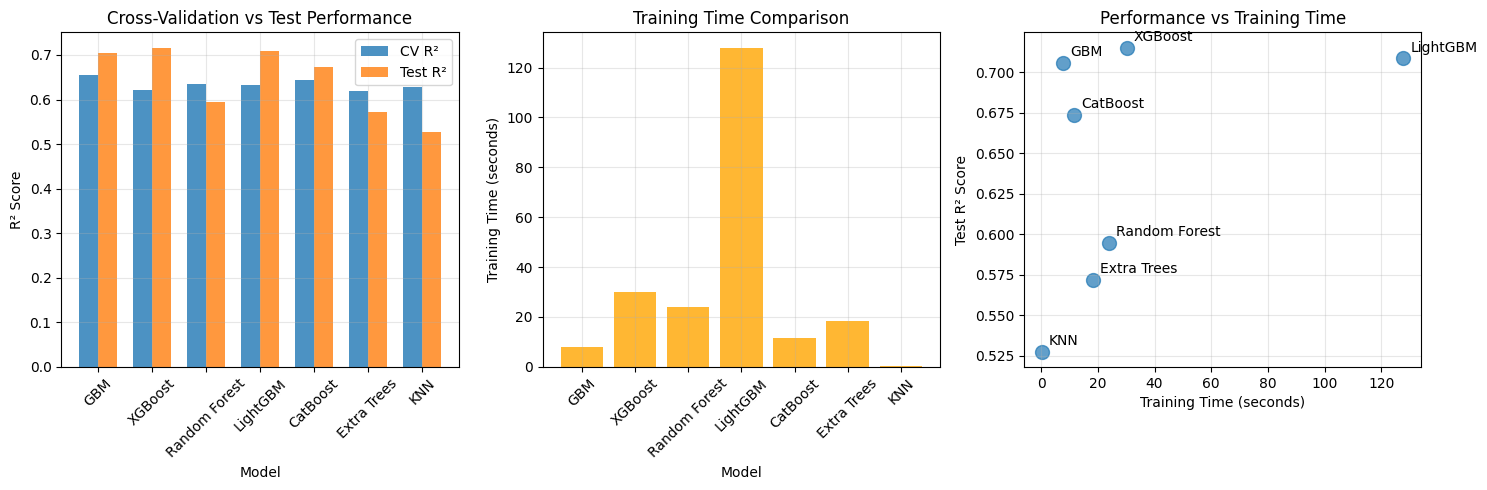

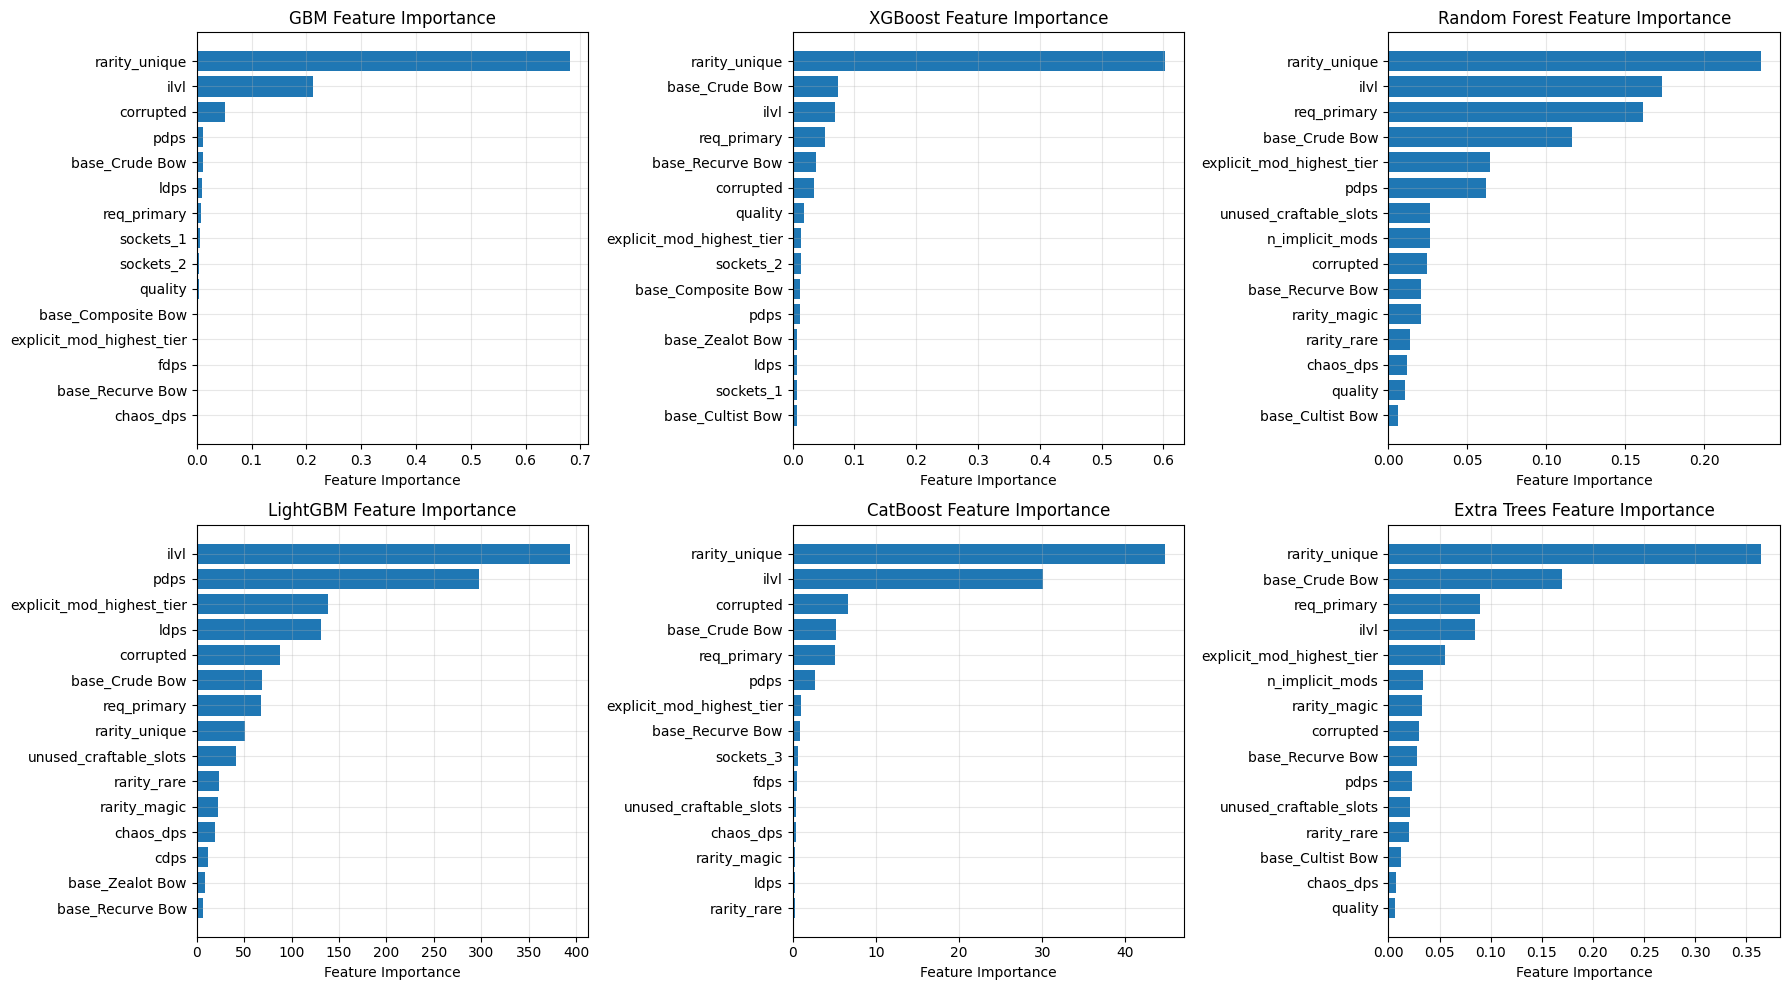

Creating ensemble from top 3 models:
  - XGBoost: 0.7151
  - LightGBM: 0.7083
  - GBM: 0.7054

Ensemble Test R²: 0.7211

Best performing model: XGBoost
Test R²: 0.7151


In [ ]:
# Train all models
results = train_and_evaluate_models(X_train, X_test, y_train, y_test)

# Print results
print_detailed_results(results)

# Plot comparisons
plot_model_comparison(results)

# Plot feature importance
plot_feature_importance(results, X_train.columns)

# Create ensemble
ensemble, ensemble_r2 = create_ensemble_model(results, X_train, X_test, y_train, y_test)
print(f"\nEnsemble Test R²: {ensemble_r2:.4f}")

# Find best model
best_model_name = max(results.keys(), key=lambda k: results[k]['test_r2'])
best_model = results[best_model_name]['model']

print(f"\nBest performing model: {best_model_name}")
print(f"Test R²: {results[best_model_name]['test_r2']:.4f}")

Though the ensemble performs better than `XGBoost` individually, because of the training time of `LightGBM`, to scale and train a model for every weapon category, I will stick with only `XGBoost`.

XGBOOST PERFORMANCE DIAGNOSTICS
Overall Test R²: 0.7151
Mean Absolute Error: 0.1104
Root Mean Squared Error: 0.2224


/var/folders/p2/mn3z9dy11rq069hcxs98ff_40000gn/T/ipykernel_74960/118192986.py:99: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_residuals = analysis_df.groupby(price_bins)['abs_residual'].agg(['mean', 'std', 'count'])
/var/folders/p2/mn3z9dy11rq069hcxs98ff_40000gn/T/ipykernel_74960/118192986.py:172: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  axes[8].boxplot(socket_data, labels=socket_labels)


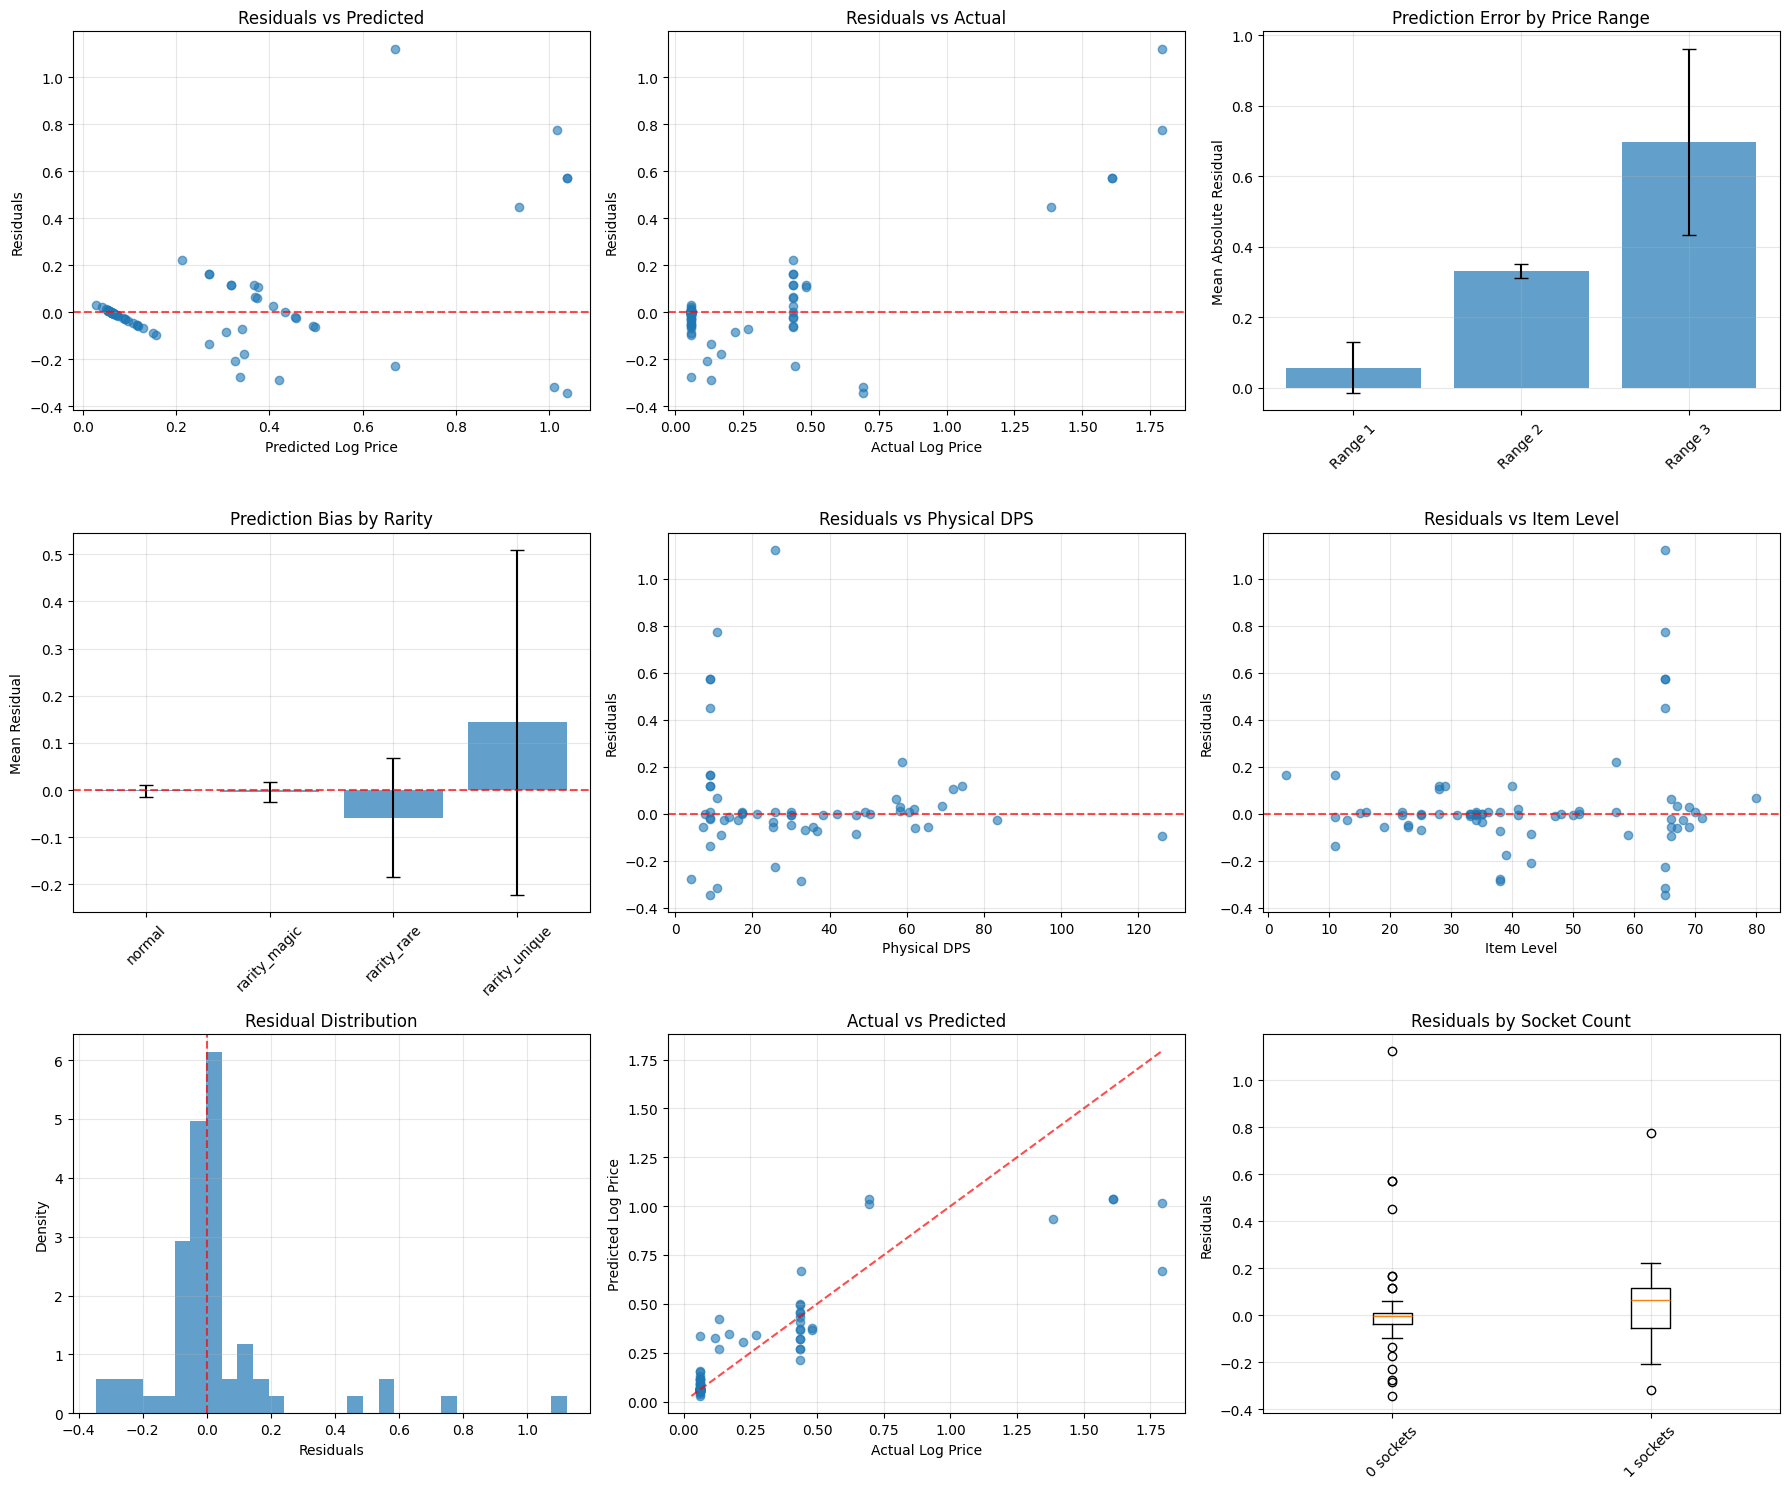


WORST PREDICTIONS ANALYSIS

Top 10 UNDER-PREDICTIONS (Model predicts too low):
--------------------------------------------------
Item 240:
  Actual: 5.0 | Predicted: 1.0 | Error: +424.7%
  Features: ilvl: 65.0 | pdps: 25.9 | rarity: unique | total_sockets: 0.0 | crit_chance: 0.1

Item 249:
  Actual: 5.0 | Predicted: 1.8 | Error: +182.9%
  Features: ilvl: 65.0 | pdps: 10.8 | rarity: unique | total_sockets: 1.0 | crit_chance: 0.1

Item 234:
  Actual: 4.0 | Predicted: 1.8 | Error: +119.4%
  Features: ilvl: 65.0 | pdps: 9.0 | rarity: unique | total_sockets: 0.0 | crit_chance: 0.1

Item 238:
  Actual: 4.0 | Predicted: 1.8 | Error: +119.4%
  Features: ilvl: 65.0 | pdps: 9.0 | rarity: unique | total_sockets: 0.0 | crit_chance: 0.1

Item 233:
  Actual: 3.0 | Predicted: 1.6 | Error: +93.4%
  Features: ilvl: 65.0 | pdps: 9.0 | rarity: unique | total_sockets: 0.0 | crit_chance: 0.1

Item 337:
  Actual: 0.5 | Predicted: 0.2 | Error: +128.9%
  Features: ilvl: 57.0 | pdps: 58.8 | rarity: rare | to

/var/folders/p2/mn3z9dy11rq069hcxs98ff_40000gn/T/ipykernel_74960/118192986.py:331: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  price_performance = analysis_df.groupby(price_bins)['abs_residual'].mean()


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.metrics import r2_score

def analyze_xgboost_performance(xgb_model, X_test, y_test, X_train=None, y_train=None, metadata=None):
    """Comprehensive analysis of where XGBoost performs poorly."""
    
    # Handle DataFrame targets
    if hasattr(y_test, 'columns'):
        y_test = y_test['log_price'] if 'log_price' in y_test.columns else y_test.iloc[:, -1]
    if y_train is not None and hasattr(y_train, 'columns'):
        y_train = y_train['log_price'] if 'log_price' in y_train.columns else y_train.iloc[:, -1]
    
    # Get predictions and residuals
    y_pred = xgb_model.predict(X_test)
    residuals = y_test - y_pred
    abs_residuals = np.abs(residuals)
    
    print("=" * 70)
    print("XGBOOST PERFORMANCE DIAGNOSTICS")
    print("=" * 70)
    print(f"Overall Test R²: {r2_score(y_test, y_pred):.4f}")
    print(f"Mean Absolute Error: {abs_residuals.mean():.4f}")
    print(f"Root Mean Squared Error: {np.sqrt((residuals**2).mean()):.4f}")
    
    # Create analysis DataFrame
    analysis_df = pd.DataFrame({
        'actual': y_test,
        'predicted': y_pred,
        'residual': residuals,
        'abs_residual': abs_residuals,
        'actual_price': np.expm1(y_test),  # Convert back from log
        'predicted_price': np.expm1(y_pred)
    }, index=X_test.index)
    
    # Add feature information for analysis
    feature_cols = ['ilvl', 'pdps', 'fdps', 'cdps', 'ldps', 'chaos_dps', 'crit_chance', 'quality', 'req_primary']
    for col in feature_cols:
        if col in X_test.columns:
            analysis_df[col] = X_test[col]
    
    # Add rarity information
    rarity_cols = [col for col in X_test.columns if col.startswith('rarity_')]
    if rarity_cols:
        # Determine dominant rarity
        rarity_data = X_test[rarity_cols]
        analysis_df['rarity'] = rarity_data.idxmax(axis=1)
        analysis_df.loc[rarity_data.sum(axis=1) == 0, 'rarity'] = 'normal'
    
    # Add socket information
    socket_cols = [col for col in X_test.columns if 'socket' in col.lower()]
    if socket_cols:
        analysis_df['total_sockets'] = X_test[socket_cols].sum(axis=1)
    
    return analysis_df

def plot_residual_patterns(analysis_df):
    """Plot various residual patterns to identify problem areas."""
    
    fig, axes = plt.subplots(3, 3, figsize=(18, 15))
    axes = axes.flatten()
    
    # 1. Residuals vs Predicted Values
    axes[0].scatter(analysis_df['predicted'], analysis_df['residual'], alpha=0.6)
    axes[0].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[0].set_xlabel('Predicted Log Price')
    axes[0].set_ylabel('Residuals')
    axes[0].set_title('Residuals vs Predicted')
    axes[0].grid(True, alpha=0.3)
    
    # 2. Residuals vs Actual Values  
    axes[1].scatter(analysis_df['actual'], analysis_df['residual'], alpha=0.6)
    axes[1].axhline(0, color='red', linestyle='--', alpha=0.7)
    axes[1].set_xlabel('Actual Log Price')
    axes[1].set_ylabel('Residuals')
    axes[1].set_title('Residuals vs Actual')
    axes[1].grid(True, alpha=0.3)
    
    # 3. Absolute Residuals by Price Range
    try:
        price_bins = pd.qcut(analysis_df['actual'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')
        price_residuals = analysis_df.groupby(price_bins)['abs_residual'].agg(['mean', 'std', 'count'])
        axes[2].bar(range(len(price_residuals)), price_residuals['mean'], 
                   yerr=price_residuals['std'], capsize=5, alpha=0.7)
        axes[2].set_xticks(range(len(price_residuals)))
        axes[2].set_xticklabels(price_residuals.index, rotation=45)
        axes[2].set_ylabel('Mean Absolute Residual')
        axes[2].set_title('Prediction Error by Price Range')
        axes[2].grid(True, alpha=0.3)
    except ValueError:
        # Fall back to simpler binning if not enough unique values
        n_unique = analysis_df['actual'].nunique()
        n_bins = min(3, n_unique - 1) if n_unique > 2 else 1
        
        if n_bins > 1:
            price_bins = pd.cut(analysis_df['actual'], bins=n_bins, labels=[f'Range {i+1}' for i in range(n_bins)])
            price_residuals = analysis_df.groupby(price_bins)['abs_residual'].agg(['mean', 'std', 'count'])
            axes[2].bar(range(len(price_residuals)), price_residuals['mean'], 
                       yerr=price_residuals['std'], capsize=5, alpha=0.7)
            axes[2].set_xticks(range(len(price_residuals)))
            axes[2].set_xticklabels(price_residuals.index, rotation=45)
        else:
            axes[2].text(0.5, 0.5, 'Not enough unique\nprice values for\nbinning analysis', 
                        ha='center', va='center', transform=axes[2].transAxes)
        
        axes[2].set_ylabel('Mean Absolute Residual')
        axes[2].set_title('Prediction Error by Price Range')
        axes[2].grid(True, alpha=0.3)
    
    # 4. Residuals by Rarity (if available)
    if 'rarity' in analysis_df.columns:
        rarity_residuals = analysis_df.groupby('rarity')['residual'].agg(['mean', 'std', 'count'])
        axes[3].bar(range(len(rarity_residuals)), rarity_residuals['mean'],
                   yerr=rarity_residuals['std'], capsize=5, alpha=0.7)
        axes[3].set_xticks(range(len(rarity_residuals)))
        axes[3].set_xticklabels(rarity_residuals.index, rotation=45)
        axes[3].set_ylabel('Mean Residual')
        axes[3].set_title('Prediction Bias by Rarity')
        axes[3].axhline(0, color='red', linestyle='--', alpha=0.7)
        axes[3].grid(True, alpha=0.3)
    
    # 5. Residuals vs PDPS (if available)
    if 'pdps' in analysis_df.columns:
        valid_pdps = analysis_df['pdps'] > 0
        if valid_pdps.sum() > 10:
            axes[4].scatter(analysis_df.loc[valid_pdps, 'pdps'], 
                          analysis_df.loc[valid_pdps, 'residual'], alpha=0.6)
            axes[4].axhline(0, color='red', linestyle='--', alpha=0.7)
            axes[4].set_xlabel('Physical DPS')
            axes[4].set_ylabel('Residuals')
            axes[4].set_title('Residuals vs Physical DPS')
            axes[4].grid(True, alpha=0.3)
    
    # 6. Residuals vs Item Level (if available)
    if 'ilvl' in analysis_df.columns:
        axes[5].scatter(analysis_df['ilvl'], analysis_df['residual'], alpha=0.6)
        axes[5].axhline(0, color='red', linestyle='--', alpha=0.7)
        axes[5].set_xlabel('Item Level')
        axes[5].set_ylabel('Residuals')
        axes[5].set_title('Residuals vs Item Level')
        axes[5].grid(True, alpha=0.3)
    
    # 7. Distribution of Residuals
    axes[6].hist(analysis_df['residual'], bins=30, alpha=0.7, density=True)
    axes[6].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[6].set_xlabel('Residuals')
    axes[6].set_ylabel('Density')
    axes[6].set_title('Residual Distribution')
    axes[6].grid(True, alpha=0.3)
    
    # 8. Actual vs Predicted (with perfect prediction line)
    axes[7].scatter(analysis_df['actual'], analysis_df['predicted'], alpha=0.6)
    min_val, max_val = analysis_df[['actual', 'predicted']].min().min(), analysis_df[['actual', 'predicted']].max().max()
    axes[7].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7)
    axes[7].set_xlabel('Actual Log Price')
    axes[7].set_ylabel('Predicted Log Price')
    axes[7].set_title('Actual vs Predicted')
    axes[7].grid(True, alpha=0.3)
    
    # 9. Box plot of residuals by total sockets (if available)
    if 'total_sockets' in analysis_df.columns:
        socket_data = []
        socket_labels = []
        for sockets in sorted(analysis_df['total_sockets'].unique()):
            if analysis_df['total_sockets'].value_counts()[sockets] >= 5:  # At least 5 items
                socket_data.append(analysis_df[analysis_df['total_sockets'] == sockets]['residual'].values)
                socket_labels.append(f'{int(sockets)} sockets')
        
        if socket_data:
            axes[8].boxplot(socket_data, labels=socket_labels)
            axes[8].set_ylabel('Residuals')
            axes[8].set_title('Residuals by Socket Count')
            axes[8].grid(True, alpha=0.3)
            axes[8].tick_params(axis='x', rotation=45)
    
    plt.tight_layout()
    plt.show()

def identify_worst_predictions(analysis_df, n_worst=10):
    """Identify and analyze the worst predictions."""
    
    print("\n" + "=" * 70)
    print("WORST PREDICTIONS ANALYSIS")
    print("=" * 70)
    
    # Get worst over-predictions and under-predictions
    worst_over = analysis_df.nlargest(n_worst, 'residual')  # Actual > Predicted (under-priced by model)
    worst_under = analysis_df.nsmallest(n_worst, 'residual')  # Actual < Predicted (over-priced by model)
    
    print(f"\nTop {n_worst} UNDER-PREDICTIONS (Model predicts too low):")
    print("-" * 50)
    for idx, row in worst_over.iterrows():
        actual_price = row['actual_price']
        pred_price = row['predicted_price']
        error_pct = (actual_price - pred_price) / pred_price * 100
        
        print(f"Item {idx}:")
        print(f"  Actual: {actual_price:.1f} | Predicted: {pred_price:.1f} | Error: +{error_pct:.1f}%")
        
        # Show key features if available
        features_to_show = ['ilvl', 'pdps', 'rarity', 'total_sockets', 'crit_chance']
        feature_info = []
        for feat in features_to_show:
            if feat in row.index and pd.notna(row[feat]):
                if feat == 'rarity':
                    feature_info.append(f"{feat}: {row[feat].replace('rarity_', '')}")
                else:
                    feature_info.append(f"{feat}: {row[feat]:.1f}")
        
        if feature_info:
            print(f"  Features: {' | '.join(feature_info)}")
        print()
    
    print(f"\nTop {n_worst} OVER-PREDICTIONS (Model predicts too high):")
    print("-" * 50)
    for idx, row in worst_under.iterrows():
        actual_price = row['actual_price']
        pred_price = row['predicted_price']
        error_pct = (pred_price - actual_price) / actual_price * 100
        
        print(f"Item {idx}:")
        print(f"  Actual: {actual_price:.1f} | Predicted: {pred_price:.1f} | Error: +{error_pct:.1f}%")
        
        # Show key features
        feature_info = []
        for feat in features_to_show:
            if feat in row.index and pd.notna(row[feat]):
                if feat == 'rarity':
                    feature_info.append(f"{feat}: {row[feat].replace('rarity_', '')}")
                else:
                    feature_info.append(f"{feat}: {row[feat]:.1f}")
        
        if feature_info:
            print(f"  Features: {' | '.join(feature_info)}")
        print()

def performance_by_segments(analysis_df):
    """Analyze performance across different segments."""
    
    print("\n" + "=" * 70)
    print("PERFORMANCE BY SEGMENTS")
    print("=" * 70)
    
    # Performance by price quintiles
    print("\nPerformance by Price Range:")
    print("-" * 40)
    
    try:
        price_bins = pd.qcut(analysis_df['actual'], q=5, labels=['Very Low', 'Low', 'Medium', 'High', 'Very High'], duplicates='drop')
    except ValueError:
        # Fall back to simpler binning
        n_unique = analysis_df['actual'].nunique()
        n_bins = min(3, n_unique - 1) if n_unique > 2 else 1
        
        if n_bins > 1:
            price_bins = pd.cut(analysis_df['actual'], bins=n_bins, labels=[f'Range {i+1}' for i in range(n_bins)])
        else:
            print("Not enough unique price values for meaningful price range analysis.")
            price_bins = None
    
    if price_bins is not None:
        for price_range in price_bins.cat.categories:
            mask = price_bins == price_range
            if mask.sum() > 0:
                segment_r2 = r2_score(analysis_df.loc[mask, 'actual'], analysis_df.loc[mask, 'predicted'])
                mean_abs_error = analysis_df.loc[mask, 'abs_residual'].mean()
                count = mask.sum()
                price_range_actual = analysis_df.loc[mask, 'actual_price']
                
                print(f"{price_range:>10} ({count:>3} items): R² = {segment_r2:.3f} | "
                      f"MAE = {mean_abs_error:.3f} | Avg Price = {price_range_actual.mean():>6.1f}")
    
    # Performance by rarity
    if 'rarity' in analysis_df.columns:
        print("\nPerformance by Rarity:")
        print("-" * 40)
        for rarity in analysis_df['rarity'].value_counts().index[:6]:  # Top 6 rarities
            mask = analysis_df['rarity'] == rarity
            if mask.sum() >= 5:  # At least 5 items
                segment_r2 = r2_score(analysis_df.loc[mask, 'actual'], analysis_df.loc[mask, 'predicted'])
                mean_abs_error = analysis_df.loc[mask, 'abs_residual'].mean()
                count = mask.sum()
                
                rarity_clean = rarity.replace('rarity_', '') if 'rarity_' in rarity else rarity
                print(f"{rarity_clean:>10} ({count:>3} items): R² = {segment_r2:.3f} | MAE = {mean_abs_error:.3f}")
    
    # Performance by DPS ranges (if available)
    if 'pdps' in analysis_df.columns:
        print("\nPerformance by Physical DPS Range:")
        print("-" * 40)
        valid_pdps = analysis_df['pdps'] > 0
        if valid_pdps.sum() > 20:
            try:
                pdps_bins = pd.qcut(analysis_df.loc[valid_pdps, 'pdps'], 
                                  q=4, labels=['Low DPS', 'Med-Low DPS', 'Med-High DPS', 'High DPS'], duplicates='drop')
                
                for dps_range in pdps_bins.cat.categories:
                    mask = pdps_bins == dps_range
                    if mask.sum() > 0:
                        valid_indices = analysis_df.loc[valid_pdps].index[mask]
                        segment_data = analysis_df.loc[valid_indices]
                        
                        segment_r2 = r2_score(segment_data['actual'], segment_data['predicted'])
                        mean_abs_error = segment_data['abs_residual'].mean()
                        count = len(segment_data)
                        avg_dps = segment_data['pdps'].mean()
                        
                        print(f"{dps_range:>12} ({count:>3} items): R² = {segment_r2:.3f} | "
                              f"MAE = {mean_abs_error:.3f} | Avg DPS = {avg_dps:>6.1f}")
            except ValueError:
                print("Not enough unique DPS values for DPS range analysis.")
        elif valid_pdps.sum() > 0:
            print(f"Only {valid_pdps.sum()} items with DPS > 0, not enough for range analysis.")
        else:
            print("No items with DPS > 0 found.")

def suggest_improvements(analysis_df):
    """Suggest improvements based on error patterns."""
    
    print("\n" + "=" * 70)
    print("IMPROVEMENT RECOMMENDATIONS")
    print("=" * 70)
    
    recommendations = []
    
    # Check for price range bias
    try:
        price_bins = pd.qcut(analysis_df['actual'], q=5, duplicates='drop')
        price_performance = analysis_df.groupby(price_bins)['abs_residual'].mean()
        worst_price_range = price_performance.idxmax()
        best_price_range = price_performance.idxmin()
        
        if price_performance.max() / price_performance.min() > 1.5:
            recommendations.append(
                f"Price range bias detected: Model struggles most with {worst_price_range} price range. "
                f"Consider separate models for different price tiers or price-specific features."
            )
    except ValueError:
        print("Note: Insufficient price variation for detailed price range analysis.")
    
    # Check for rarity bias
    if 'rarity' in analysis_df.columns:
        rarity_bias = analysis_df.groupby('rarity')['residual'].mean()
        max_bias_rarity = rarity_bias.abs().idxmax()
        
        if rarity_bias.abs().max() > 0.1:  # Significant bias
            bias_direction = "under-predicting" if rarity_bias[max_bias_rarity] > 0 else "over-predicting"
            recommendations.append(
                f"Rarity bias: Model is {bias_direction} {max_bias_rarity.replace('rarity_', '')} items. "
                f"Consider rarity-specific feature engineering or interaction terms."
            )
    
    # Check for outlier concentration
    outlier_threshold = analysis_df['abs_residual'].quantile(0.95)
    outlier_count = (analysis_df['abs_residual'] > outlier_threshold).sum()
    outlier_pct = outlier_count / len(analysis_df) * 100
    
    if outlier_pct > 10:
        recommendations.append(
            f"High outlier rate: {outlier_pct:.1f}% of predictions are outliers. "
            f"Consider outlier detection/removal or robust loss functions."
        )
    
    # Check for feature range issues
    if 'pdps' in analysis_df.columns:
        high_dps_mask = analysis_df['pdps'] > analysis_df['pdps'].quantile(0.9)
        if high_dps_mask.sum() > 5:
            high_dps_error = analysis_df.loc[high_dps_mask, 'abs_residual'].mean()
            overall_error = analysis_df['abs_residual'].mean()
            
            if high_dps_error > overall_error * 1.3:
                recommendations.append(
                    "High-DPS items have elevated prediction errors. "
                    "Consider log-transforming DPS features or adding DPS interaction terms."
                )
    
    if not recommendations:
        recommendations.append("No major systematic biases detected. Consider ensemble methods or fine-tuning hyperparameters.")
    
    for i, rec in enumerate(recommendations, 1):
        print(f"{i}. {rec}")
    
    print(f"\nOverall Model Assessment:")
    print(f"- Test R²: {r2_score(analysis_df['actual'], analysis_df['predicted']):.4f}")
    print(f"- Mean Absolute Error: {analysis_df['abs_residual'].mean():.4f}")
    print(f"- 95th Percentile Error: {analysis_df['abs_residual'].quantile(0.95):.4f}")

# Usage function
def full_xgboost_analysis(xgb_model, X_test, y_test, X_train=None, y_train=None):
    """Run complete XGBoost diagnostic analysis."""
    
    # Run analysis
    analysis_df = analyze_xgboost_performance(xgb_model, X_test, y_test, X_train, y_train)
    
    # Plot patterns
    plot_residual_patterns(analysis_df)
    
    # Identify worst cases
    identify_worst_predictions(analysis_df)
    
    # Segment analysis
    performance_by_segments(analysis_df)
    
    # Suggestions
    suggest_improvements(analysis_df)
    
    return analysis_df

# Run the analysis (use your best XGBoost model)
best_xgb_model = results['XGBoost']['model']  # From your previous training
analysis_results = full_xgboost_analysis(best_xgb_model, X_test, y_test, X_train, y_train)

Nearly all worst under-predictions are unique rarity items with low raw stats but high actual prices. One idea is to use a hybrid approach where if we encounter a unique item we scrape the POE2 website and do a comparable analysis. I will use a hybrid approach where if we encounter a unique item we search the POE2 website for exact matches including mods with equal or greater values to compare prices.